# Accident Risk Assessment

**Task:**  
- Develop a system for predicting the risk of road traffic accidents (RTAs) based on historical accident data from a specific region.  

The system aims to assess the probability of an accident on a selected driving route in real time. When a user books a car, starts driving, and selects a route, the system should analyze the route and provide a risk level assessment. If the probability of an accident is high, the system will alert the driver and suggest alternative routes to reduce the risk of a crash.  

**Client Requirements for the Algorithm:**  
- The model should focus on cases where the at-fault party is a car only.  
- Only accidents that resulted in any vehicle damage, excluding "SCRATCH", should be considered.  
- The modeling should be limited to data from the year 2012, as it is the most recent dataset available.  
- The model should take the vehicle's age into account.

**Source Data**  

- **General Accident Information** – *collisions* table. Contains a unique `case_id`. This table provides general details about the accident, such as its location and time.  

- **Accident Participants Information** – *parties* table. Contains a non-unique `case_id`, which links to the corresponding accident in the *collisions* table. Each row represents one of the parties involved in the accident. If two cars were involved in a collision, this table should contain two rows with the same `case_id`. This table also includes the target variable `at_fault` (responsible party).  

- **Damaged Vehicles Information** – *vehicles* table. Contains non-unique `case_id` and `party_number`, which link to the *collisions* and *parties* tables.

# Key Project Stages:

**Plan**  

1. Load the data tables from the client’s server.  
2. Initial exploration of the data tables.  
3. Statistical analysis of accident factors.  
4. Select features for model development and conduct an exploratory analysis of the selected features.  
5. Choose an evaluation metric for the model.  
6. Develop models to assess accident probability and select the best-performing model.  
7. Analyze the results of the best model.  
8. Assess the importance of accident factors.  
9. Draw conclusions and provide recommendations.

## Data Table Loading

In [1]:
!pip install phik -q
!pip install shap -q
!pip install lightgbm
!pip install category_encoders

In [2]:
# Importing Libraries

import warnings
import numpy as np
import pandas as pd
import shap
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy import stats
from phik.report import plot_correlation_matrix
from matplotlib import pyplot as plt
from sqlalchemy import create_engine
from warnings import simplefilter

# Importing Scikit-Learn and other ML tools
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV,
    cross_val_score
)
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler, 
    LabelEncoder, 
    OrdinalEncoder, 
    MinMaxScaler, 
    FunctionTransformer
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import CatBoostEncoder


# Importing machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# Metrics and evaluation functions
from sklearn.metrics import (
    make_scorer, 
    f1_score, 
    accuracy_score, 
    recall_score, 
    precision_score, 
    confusion_matrix
)

In [3]:
db_config = {
'user': 'XXX',
'pwd': 'XXX', 
'host': 'XXX',
'port': XXX, 
'db': 'data-science-vehicle-db' # Database Name
} 

In [4]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
engine = create_engine(connection_string)

Database connection established.

# Initial Table Exploration

Checking for Available Tables in the Database

In [6]:
query = ''' SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'public';'''

tables_df = pd.read_sql(query, engine)
tables_df

,table_name
0,case_ids
1,collisions
2,parties
3,vehicles


## Откроем таблицы и ознакомимся с ними

In [7]:
query = '''
SELECT COUNT(*) as count
FROM case_ids
'''
print('Number of rows in the table case_ids: ', pd.read_sql(query, engine)['count'][0])

query = '''
SELECT COUNT(*) as count
FROM INFORMATION_SCHEMA.COLUMNS
WHERE table_name = 'case_ids'
'''
print('Number of rows in the table case_ids: ', pd.read_sql(query, engine)['count'][0])

query = '''
SELECT *
FROM case_ids
LIMIT 10
'''
pd.read_sql(query, engine)

Number of rows in the table case_ids:  1400000
Number of rows in the table case_ids:  2


,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
5,3899445,2021
6,3899446,2021
7,3899449,2021
8,3899450,2021
9,3899453,2021


In [8]:
pd.read_sql(query, engine).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   case_id  10 non-null     object
 1   db_year  10 non-null     object
dtypes: object(2)
memory usage: 288.0+ bytes


Таблица case_ids имеет 2 столбца, 1 400 000 строк, данные заполнены

### vehicles

In [9]:
query = '''
SELECT COUNT(*) as count
FROM vehicles
'''
print('Number of rows in the table vehicles: ', pd.read_sql(query, engine)['count'][0])

query = '''
SELECT COUNT(*) as count
FROM INFORMATION_SCHEMA.COLUMNS
WHERE table_name = 'vehicles'
'''
print('Number of rows in the table vehicles: ', pd.read_sql(query, engine)['count'][0])

query = '''
SELECT *
FROM vehicles
LIMIT 10
'''
pd.read_sql(query, engine)

Number of rows in the table vehicles:  1021234
Number of rows in the table vehicles:  6


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


In [10]:
pd.read_sql(query, engine).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    10 non-null     int64 
 1   case_id               10 non-null     object
 2   party_number          10 non-null     int64 
 3   vehicle_type          10 non-null     object
 4   vehicle_transmission  10 non-null     object
 5   vehicle_age           10 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


The **vehicles** table contains 6 columns and 1,021,234 rows, with all data populated.

- 'id' - Record number in the table  
- 'case_id' - Unique identifier for a registered incident in the accidents table  
- 'party_number' - Participant number in the accident  
- 'vehicle_type' - Vehicle type  
- 'vehicle_transmission' - Transmission type  
- 'vehicle_age' - Vehicle age (in years)

### parties

In [11]:
query = '''
SELECT COUNT(*) as count
FROM parties
'''
print('Number of rows in the table parties: ', pd.read_sql(query, engine)['count'][0])

query = '''
SELECT COUNT(*) as count
FROM INFORMATION_SCHEMA.COLUMNS
WHERE table_name = 'parties'
'''
print('Number of columns in the table parties: ', pd.read_sql(query, engine)['count'][0])

query = '''
SELECT *
FROM parties
LIMIT 10
'''
pd.read_sql(query, engine)

Number of rows in the table parties:  2752408
Number of columns in the table parties:  9


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


In [12]:
pd.read_sql(query, engine).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10 non-null     int64  
 1   case_id              10 non-null     object 
 2   party_number         10 non-null     int64  
 3   party_type           10 non-null     object 
 4   at_fault             10 non-null     int64  
 5   insurance_premium    4 non-null      float64
 6   party_sobriety       10 non-null     object 
 7   party_drug_physical  4 non-null      object 
 8   cellphone_in_use     9 non-null      float64
dtypes: float64(2), int64(3), object(4)
memory usage: 848.0+ bytes


The **parties** table contains 9 columns and 2,752,408 rows, with all data populated.

- 'case_id' - Identification number in the database  
- 'party_number' - Incident participant number  
- 'party_type' - Type of incident participant  
- 'at_fault' - Fault status of the participant  
- 'insurance_premium' - Insurance amount (in thousand $)  
- 'party_sobriety' - Participant's sobriety  
- 'party_drug_physical' - Participant's condition: physical state or affected by medication  
- 'cellphone_in_use' - Presence of a phone in the vehicle (hands-free capability)

### collisions

In [13]:
query = '''
SELECT COUNT(*) as count
FROM collisions
'''
print('Number of rows in the table collisions: ', pd.read_sql(query, engine)['count'][0])

query = '''
SELECT COUNT(*) as count
FROM INFORMATION_SCHEMA.COLUMNS
WHERE table_name = 'collisions'
'''
print('v collisions: ', pd.read_sql(query, engine)['count'][0])

query = '''
SELECT *
FROM collisions
LIMIT 10
'''
pd.read_sql(query, engine)

Number of rows in the table collisions:  1400000
v collisions:  20


,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


In [14]:
pd.read_sql(query, engine).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   case_id                      10 non-null     object 
 1   county_city_location         10 non-null     object 
 2   county_location              10 non-null     object 
 3   distance                     10 non-null     float64
 4   direction                    4 non-null      object 
 5   intersection                 10 non-null     int64  
 6   weather_1                    10 non-null     object 
 7   location_type                5 non-null      object 
 8   collision_damage             10 non-null     object 
 9   party_count                  10 non-null     int64  
 10  primary_collision_factor     10 non-null     object 
 11  pcf_violation_category       9 non-null      object 
 12  type_of_collision            10 non-null     object 
 13  motor_vehicle_involved_

The **parties** table contains 20 columns and 1,400,000 rows, with all data populated.

- 'case_id' - Identification number in the database  
- 'county_city_location' - Geographic region code where the accident occurred  
- 'county_location' - Name of the geographic region where the accident occurred  
- 'distance' - Distance from the main road (meters)  
- 'direction' - Direction of movement  
- 'intersection' - Whether the accident occurred at an intersection  
- 'weather_1' - Weather conditions  
- 'location_type' - Type of road  
- 'collision_damage' - Severity of the accident  
- 'party_count' - Number of participants  
- 'primary_collision_factor' - Primary cause of the accident  
- 'pcf_violation_category' - Violation category  
- 'type_of_collision' - Type of accident  
- 'motor_vehicle_involved_with' - Additional participants in the accident  
- 'road_surface' - Road surface condition  
- 'road_condition_1' - Road conditions  
- 'lighting' - Lighting conditions  
- 'control_device' - Traffic control device  
- 'collision_date' - Date of the accident  
- 'collision_time' - Time of the accident

In 2012, the number of accidents (1,400,000) significantly exceeds the number of registered participant vehicles (1,021,234), indicating incomplete data in the **vehicles** table.  

We will determine how many drivers have information available in both the **accidents** and **vehicles** tables, considering all client requirements.

In [15]:
query = '''
SELECT COUNT(DISTINCT p.id)
FROM parties p
LEFT JOIN collisions c ON c.case_id = p.case_id
LEFT JOIN vehicles v ON c.case_id = v.case_id AND p.party_number = v.party_number
WHERE party_type = 'car'
      AND collision_damage <> 'scratch'
      AND EXTRACT(YEAR FROM collision_date::date) = '2012'
      AND v.id IS NOT NULL
      AND p.party_number IS NOT NULL'''
print('Number of drivers with information on both accidents and vehicles.: ', pd.read_sql(query, engine)['count'][0])

Number of drivers with information on both accidents and vehicles.:  56248


**Conclusion:**  

The data tables have been opened and reviewed. The content of the tables matches the data descriptions.  

It was found that the **vehicles** table lacks data for many accidents and participants. We analyzed how many drivers have complete information on both accidents and vehicles for the year 2012, considering the client’s requirements. As a result, there are **56,248** such observations, which is sufficient for the study.  

The common key for all tables is the **case_id** accident identifier. Additionally, accident participants from the **parties** table are linked to their vehicles in the **vehicles** table using the combination of **case_id** and **party_number** (participant number within a specific accident).

# Statistical Analysis of Accident Factors

### Number of accidents by month

In [16]:
query = '''SELECT case_id, 
                  EXTRACT(MONTH FROM collision_date) AS month
           FROM collisions
           WHERE party_count = '1' '''
collision_date = pd.read_sql(query, engine)
collision_date.head()

,case_id,month
0,4083075,1.0
1,4083116,1.0
2,4083182,1.0
3,4083204,1.0
4,4083369,1.0


In [17]:
# Calculation of the number of accidents by month
collision_date['month'].value_counts()

3.0     27677
1.0     26853
2.0     25946
5.0     25586
4.0     25435
12.0    22299
10.0    21787
11.0    20088
6.0     20035
8.0     19974
7.0     19963
9.0     19123
Name: month, dtype: int64

### Chart

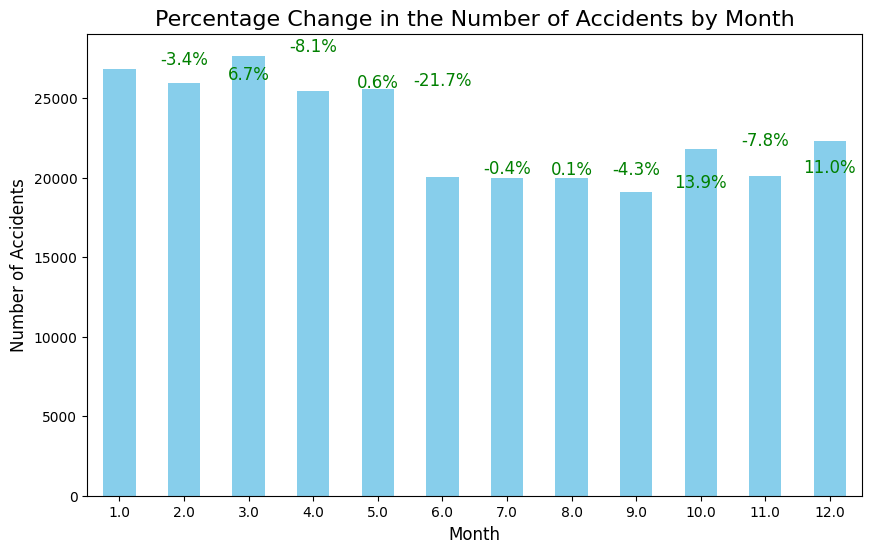

In [18]:
# Counting the number of accidents per month
month_counts = collision_date['month'].value_counts().sort_index()

# Calculating the percentage change compared to the previous month
month_counts_sorted = month_counts.sort_index()  # Sorting by months
percentage_change = month_counts_sorted.pct_change() * 100  # Calculating percentage change

# Plotting the chart with the percentage change in the number of accidents
plt.figure(figsize=(10, 6))
bars = month_counts.plot(kind='bar', color='skyblue')

# Adding titles and labels
plt.title('Percentage Change in the Number of Accidents by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)

# Adding percentage changes on the bars
for i, change in enumerate(percentage_change):
    if pd.notna(change): 
        plt.text(i, month_counts[i] + 0.3, f'{change:.1f}%', ha='center', va='bottom', fontsize=12, color='green')


plt.xticks(rotation=0)
plt.show()


### **Conclusion**:

Based on the results, the following conclusions can be drawn regarding the number of accidents by month:

- The highest number of accidents occurred between January and May, which may be explained by weather conditions and shorter daylight hours.  
- Summer and autumn months see fewer traffic accidents.  
- A sharp decline in accidents is observed in June, possibly due to people moving to summer homes and students finishing their academic year.

### Analysis of Factors Influencing Traffic Accidents

### To identify the most significant risk factors for traffic accidents, the following analytical tasks need to be addressed: 

1. Evaluate the relationship between the severity of vehicle damage and the age of the vehicle.  
2. Evaluate the correlation between the severity of vehicle damage and the sobriety of the accident participant.  
3. Analyze the impact of road surface conditions (ROAD_SURFACE) on the severity of vehicle damage.  
4. Determine the primary contributing factor to accidents.  
5. Examine the relationship between the severity of vehicle damage and the presence of a hands-free phone system in the vehicle.  
6. Evaluate the influence of weather conditions (WEATHER_1) on the severity of vehicle damage.

#### 1.Evaluate the relationship between the severity of vehicle damage and the age of the vehicle.

**Task:**  

Evaluate the relationship between the severity of vehicle damage and the age of the vehicle.  

**Steps:**  

1.1. Create an SQL query to retrieve data on vehicle damage severity and vehicle age based on the tables `collisions_df` and `vehicles_df`. The tables are linked by the case identification number (`case_id`). The query should include the columns `collision_damage` (damage severity) and `vehicle_age` (vehicle age).  

1.2. Plot a chart.  
1.3. Draw conclusions based on the chart:  

- Is there a correlation between vehicle age and damage severity?  
- How does damage severity change depending on vehicle age (e.g., does damage severity increase with age)?

In [19]:
# SQL query
query = '''SELECT 
    c.case_id, 
    c.collision_damage, 
    v.vehicle_age
FROM collisions c 
JOIN vehicles v ON c.CASE_ID = v.case_id'''
damage_vehicle_age = pd.read_sql(query, engine)
damage_vehicle_age

,case_id,collision_damage,vehicle_age
0,5305162,small damage,8.0
1,4091920,scratch,11.0
2,5305300,small damage,6.0
3,5365340,small damage,3.0
4,5366604,scratch,7.0
...,...,...,...
1021229,5303279,small damage,3.0
1021230,5303775,small damage,4.0
1021231,5304280,small damage,4.0
1021232,5304704,small damage,4.0


In [20]:
print(damage_vehicle_age['collision_damage'].isna().sum())
print(damage_vehicle_age['vehicle_age'].isna().sum())

0
24582


In [21]:
print(damage_vehicle_age['collision_damage'].unique())
print(damage_vehicle_age['vehicle_age'].unique())

['small damage' 'scratch' 'middle damage' 'severe damage' 'fatal']
[  8.  11.   6.   3.   7.   5.   9.   0.   2.   4.  nan   1.  10.  14.
  12.  15.  13.  16.  18.  17.  19. 161.  20.]


We observe an anomalous vehicle age value of 161 years.  

Let's assume that 161 represents the vehicle's age in months.

In [22]:
damage_vehicle_age.loc[damage_vehicle_age['vehicle_age'] == 161, 'vehicle_age'] = 13
print(damage_vehicle_age['vehicle_age'].unique())

[ 8. 11.  6.  3.  7.  5.  9.  0.  2.  4. nan  1. 10. 14. 12. 15. 13. 16.
 18. 17. 19. 20.]


In [23]:
# Counting the occurrences of each type of damage
damage_counts = damage_vehicle_age['collision_damage'].value_counts()

# Calculating the percentage for each type of damage
damage_percent = round(damage_counts / damage_counts.sum() * 100, 2)

# Combining the counts and percentages into a single DataFrame
result = pd.DataFrame({'Count': damage_counts, 'Percentage (%)': damage_percent})
print(result)

                Count  Percentage (%)
scratch        460059           45.05
small damage   283413           27.75
middle damage  221523           21.69
severe damage   41096            4.02
fatal           15143            1.48


**Chart**

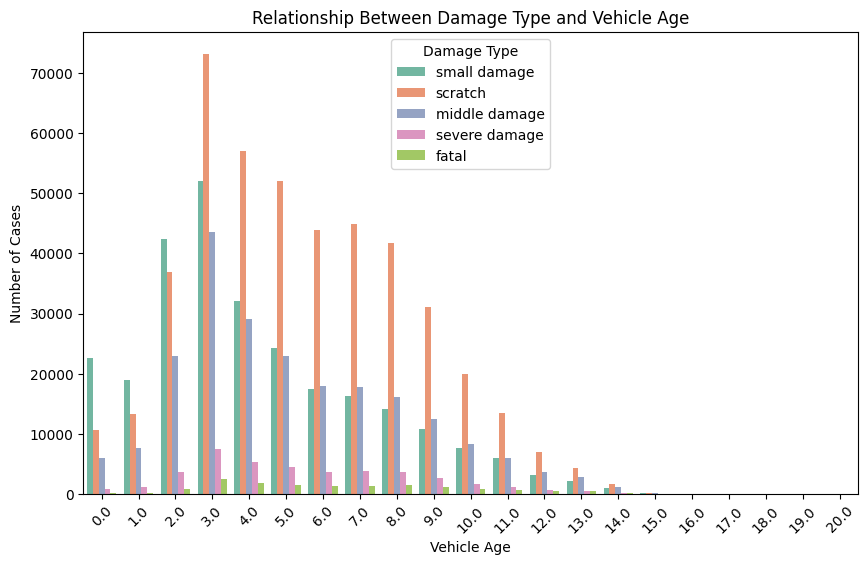

In [24]:
plt.figure(figsize=(10, 6))
sns.countplot(x='vehicle_age', hue='collision_damage', data=damage_vehicle_age, palette='Set2')

# Chart settings
plt.title('Relationship Between Damage Type and Vehicle Age')  
plt.xlabel('Vehicle Age')  
plt.ylabel('Number of Cases')  
plt.legend(title='Damage Type')
plt.xticks(rotation=45)
plt.show()

**Conclusions:**  
- The majority of collisions (over 70%) result in minor damage (scratches or small dents), indicating that many accidents occur at low speeds or in urban environments.  
- Only a small percentage of accidents (around 2%) lead to severe damage or fatal consequences, showing that while serious accidents are less frequent, they are significantly more destructive.  

**Three-year-old vehicles often fall into a high-risk accident category due to the following possible reasons:**  

- **Decreased driver attentiveness:** By this time, owners have become accustomed to their vehicles, which may lead to reduced attention while driving. They become more relaxed and less cautious.  
- **Increased mileage:** Over three years, a vehicle may accumulate significant mileage, increasing the likelihood of wear and tear on critical components (tires, brakes, etc.), which can impact safety.  
- **Ownership changes:** Three-year-old cars are frequently resold, and new owners may not yet be fully familiar with handling the vehicle, increasing the risk of accidents.  
- **Loss of factory settings and part replacements:** Some safety components may have been replaced or modified over three years (e.g., headlights, brake pads), and their quality may be lower than the original factory parts.  
- **Operating conditions:** After three years, a car may require more frequent maintenance and repairs, which could affect its road performance if repairs were not done properly.

#### 2. Evaluate the correlation between the severity of vehicle damage and the sobriety of the accident participant.  

- Use the **collisions** and **vehicles** tables. In the **collisions** table, the **collision_damage** field represents the severity of vehicle damage, while the **sobriety** field contains information about the sobriety of the participants. Assess the relationship between the severity of vehicle damage and the sobriety of the accident participants.  

- Create a chart to visualize the correlation between participant sobriety and the severity of damage.  

A bar chart can be used, where the **X-axis** represents the severity of damage, and the **Y-axis** represents the categories of participant sobriety. 
- Create a graph to analyze the relationship between fault in an accident and the participant's level of sobriety.  

- Draw conclusions based on the analysis and the charts. Determine how the sobriety of participants influences the extent of vehicle damage in accidents.

In [25]:
# SQL query
query = '''SELECT 
    c.collision_damage, 
    p.party_sobriety,
    p.at_fault
FROM collisions c 
JOIN parties p ON c.CASE_ID = p.case_id'''
damage_soberty = pd.read_sql(query, engine)
damage_soberty

,collision_damage,party_sobriety,at_fault
0,scratch,had not been drinking,1
1,small damage,not applicable,0
2,fatal,had not been drinking,1
3,middle damage,impairment unknown,1
4,small damage,not applicable,0
...,...,...,...
2752403,small damage,had not been drinking,1
2752404,severe damage,had not been drinking,1
2752405,small damage,had not been drinking,1
2752406,middle damage,had not been drinking,1


In [26]:
print(damage_soberty['collision_damage'].isna().sum())
print(damage_soberty['party_sobriety'].isna().sum())

0
73955


Fill missing values in the 'party_sobriety' column with 'had not been drinking', assuming that the absence of other data indicates the person was sober.

In [27]:
damage_soberty['party_sobriety'] = damage_soberty['party_sobriety'].fillna('had not been drinking')

In [28]:
print(damage_soberty['party_sobriety'].isna().sum())

0


In [29]:
print(damage_soberty['collision_damage'].unique())
print(damage_soberty['party_sobriety'].unique())

['scratch' 'small damage' 'fatal' 'middle damage' 'severe damage']
['had not been drinking' 'not applicable' 'impairment unknown'
 'had been drinking, under influence'
 'had been drinking, impairment unknown'
 'had been drinking, not under influence']


In [30]:
# Grouping by 'party_sobriety' and 'collision_damage', counting the number of cases
summary_table = damage_soberty.groupby(['party_sobriety', 'collision_damage']).size().unstack(fill_value=0)

# Adding percentages for each row
summary_table_percent = round(summary_table.div(summary_table.sum(axis=1), axis=0) * 100, 2)

# Displaying the table with absolute values
print("Table with absolute values:")
print(summary_table)

Table with absolute values:
collision_damage                        fatal  middle damage  scratch  \
party_sobriety                                                          
had been drinking, impairment unknown     436           2512     3032   
had been drinking, not under influence    368           3167     4443   
had been drinking, under influence       3681          22197    16462   
had not been drinking                   12924         258435   654574   
impairment unknown                       1871          14281    34345   
not applicable                            674          15340    21332   

collision_damage                        severe damage  small damage  
party_sobriety                                                       
had been drinking, impairment unknown            1144         14295  
had been drinking, not under influence            711          8961  
had been drinking, under influence               6101         63972  
had not been drinking                

In [31]:
# Displaying the table with percentages
print("\nTable with percentages:")
print(summary_table_percent)


Table with percentages:
collision_damage                        fatal  middle damage  scratch  \
party_sobriety                                                          
had been drinking, impairment unknown    2.04          11.73    14.16   
had been drinking, not under influence   2.08          17.94    25.17   
had been drinking, under influence       3.27          19.75    14.64   
had not been drinking                    0.59          11.75    29.77   
impairment unknown                       0.80           6.13    14.75   
not applicable                           0.40           9.06    12.60   

collision_damage                        severe damage  small damage  
party_sobriety                                                       
had been drinking, impairment unknown            5.34         66.74  
had been drinking, not under influence           4.03         50.77  
had been drinking, under influence               5.43         56.91  
had not been drinking                   

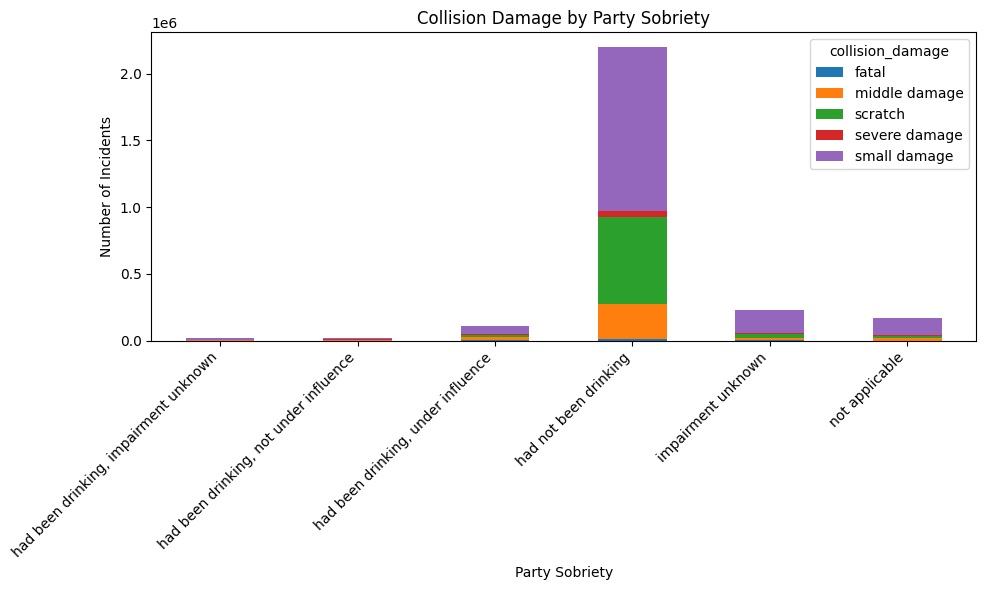

In [32]:
summary_table.plot(kind='bar', stacked=True, figsize=(10, 6))

# Setting up titles and labels.
plt.title('Collision Damage by Party Sobriety')
plt.xlabel('Party Sobriety')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45, ha="right")

# Displaying the chart
plt.tight_layout()
plt.show()

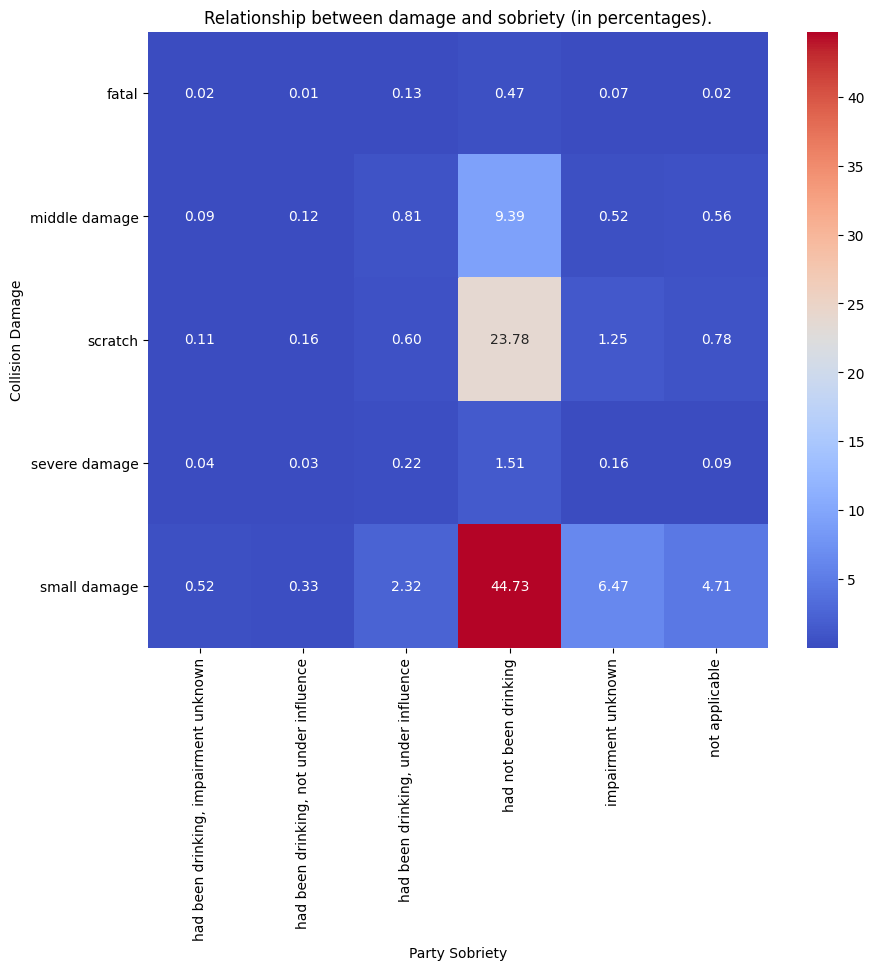

In [33]:
# Counting the occurrences of each combination of values
pivot_table = pd.crosstab(damage_soberty['collision_damage'], damage_soberty['party_sobriety'])

# Converting values to percentages
pivot_table_percent = pivot_table.div(pivot_table.sum().sum()) * 100

# Creating a heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(pivot_table_percent, annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title('Relationship between damage and sobriety (in percentages).')
plt.xlabel('Party Sobriety')
plt.ylabel('Collision Damage')

ax.set_yticklabels(ax.get_yticklabels(), rotation=360)

plt.show()

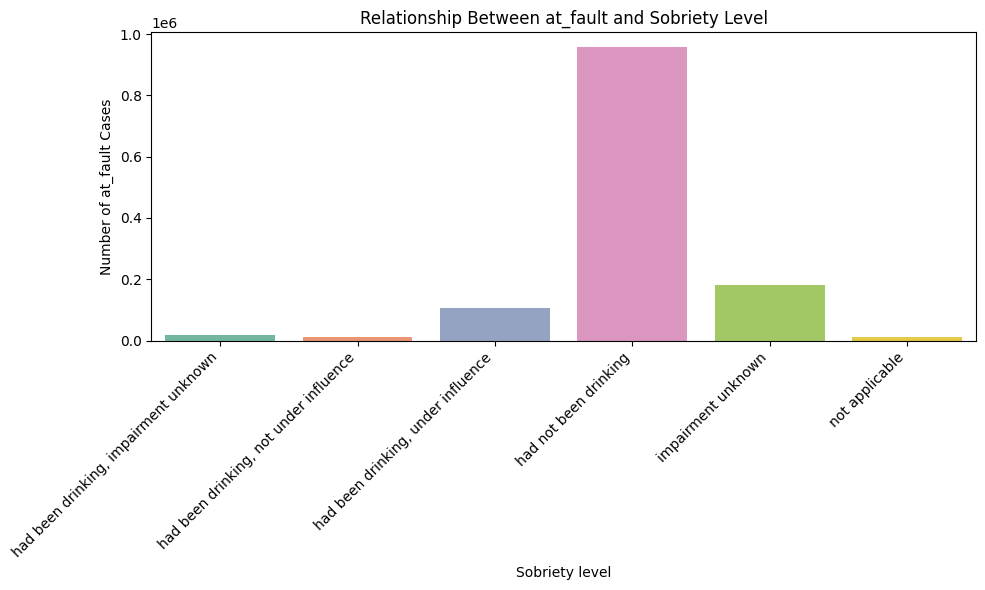

In [34]:
# Grouping data by sobriety level and counting the number of at_fault cases
sobriety_fault_counts = damage_soberty.groupby('party_sobriety')['at_fault'].sum()

# Creating a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=sobriety_fault_counts.index, y=sobriety_fault_counts.values, palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Sobriety level')
plt.ylabel('Number of at_fault Cases')  
plt.title('Relationship Between at_fault and Sobriety Level')
plt.tight_layout()
plt.show()

**CONCLUSION**  

**Sober drivers are less likely to be involved in severe accidents:**  
- Although sober participants are involved in the highest number of accidents, the vast majority of these cases result in minor or no damage. Only **0.59%** of accidents involving sober drivers were fatal, and **1.89%** were serious. This highlights the importance of sober driving in reducing the severity of traffic accidents.  

**Alcohol significantly increases the risk of severe accidents:**  
- Participants under the influence of alcohol exhibit a much higher rate of fatal and severe accidents. **3.27%** of fatal cases and **5.43%** of serious damage incidents in the "under influence" category confirm a direct correlation between alcohol consumption and the risk of severe consequences.  

**Uncertain sobriety is also a risk factor:**  
- Cases where the sobriety level is unclear show a relatively high risk of serious damage (**1.88%**) and fatal outcomes (**0.80%**), emphasizing the importance of accurately assessing a driver’s condition on the road.  

**Final Conclusion:**  
The key takeaway from the data is that **driving under the influence of alcohol or in an uncertain sobriety state significantly increases the risk of fatal accidents and severe damage**. While sober drivers are more commonly involved in minor incidents with minimal damage, alcohol consumption **drastically raises the likelihood of severe consequences**.

### Additional tasks

#### 3. Analyze the impact of road surface conditions (ROAD_SURFACE) on the severity of vehicle damage.  

- Use the **collisions** table. In this table, the **collision_damage** field represents the severity of vehicle damage, while the **road_surface** field contains information about road surface conditions. Assess the relationship between the severity of vehicle damage and road surface conditions.  

- Create a chart to visualize the correlation between road surface conditions and damage severity.  

- Draw conclusions based on the analysis and the chart. Determine how road surface conditions may influence the extent of vehicle damage in accidents.

In [35]:
# SQL query
query = '''SELECT 
    collision_damage, 
    road_surface
FROM collisions '''
damage_road = pd.read_sql(query, engine)
damage_road

,collision_damage,road_surface
0,small damage,wet
1,small damage,dry
2,scratch,dry
3,scratch,dry
4,scratch,dry
...,...,...
1399995,middle damage,dry
1399996,middle damage,dry
1399997,middle damage,dry
1399998,middle damage,dry


In [36]:
damage_road.isna().sum()

collision_damage        0
road_surface        13093
dtype: int64

In [37]:
damage_road['road_surface'] = damage_road['road_surface'].fillna('not stated')
damage_road['road_surface'].isna().sum()

0

In [38]:
print(damage_road['collision_damage'].unique())
print(damage_road['road_surface'].unique())

['small damage' 'scratch' 'severe damage' 'middle damage' 'fatal']
['wet' 'dry' 'not stated' 'slippery' 'snowy']


In [39]:
# Counting the occurrences of each type of road surface
damage_counts = damage_road['road_surface'].value_counts()

# Calculating the percentage for each type of road surface
damage_percent = round(damage_counts / damage_counts.sum() * 100, 2)

# Combining the counts and percentages into a single DataFrame
result = pd.DataFrame({'Count': damage_counts, 'Percentage (%)': damage_percent})
print(result)

              Count  Percentage (%)
dry         1242026           88.72
wet          136236            9.73
not stated    13093            0.94
snowy          7261            0.52
slippery       1384            0.10


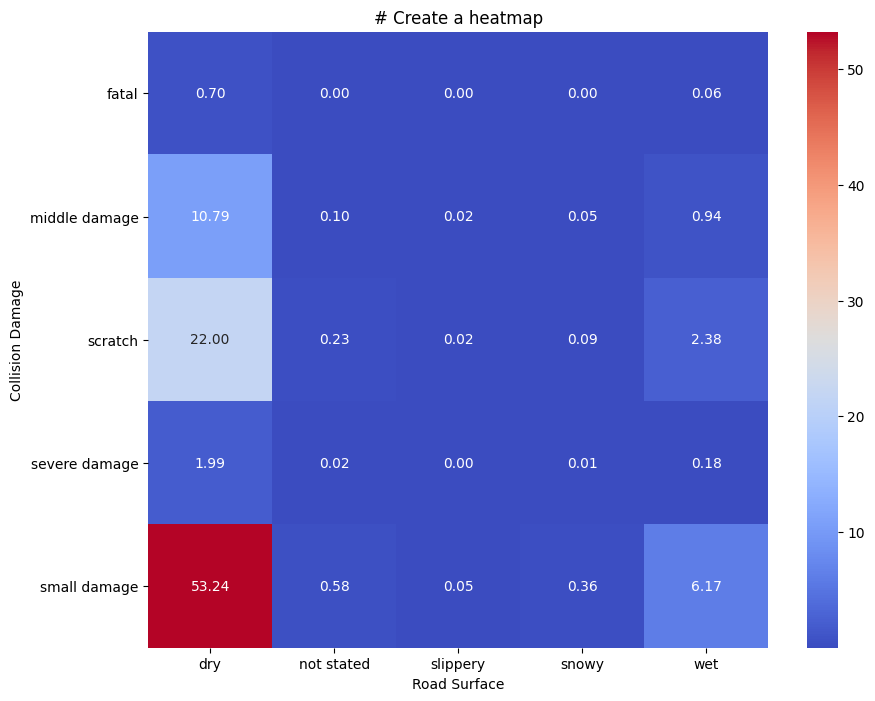

In [40]:
# Count the occurrences of each combination of values
pivot_table = pd.crosstab(damage_road['collision_damage'], damage_road['road_surface'])

# Convert values to percentages
pivot_table_percent = pivot_table.div(pivot_table.sum().sum()) * 100

# Create a heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(pivot_table_percent, annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title('# Create a heatmap')
plt.xlabel('Road Surface')
plt.ylabel('Collision Damage')

ax.set_yticklabels(ax.get_yticklabels(), rotation=360)

plt.show()

**Conclusions:**  
- **Dry roads** are the most common surface condition where accidents occur, indicating that driver safety is not solely dependent on road conditions. 
- **Wet and slippery roads** pose a significant hazard, and despite being less frequent, they present an increased risk for drivers.  
- **Snowy and icy surfaces** result in a relatively small number of accidents, likely due to seasonal factors and driving conditions that limit road usage.

####  4. Determine the primary contributing factor to accidents.  

- Identify the **primary factor** contributing to accidents.  
- Use the **collisions** table, specifically the **primary_collision_factor** field.  
- Draw conclusions based on the analysis results.

In [41]:
# SQL query
query = '''SELECT 
primary_collision_factor
FROM collisions '''
damage_primary_factor = pd.read_sql(query, engine)
damage_primary_factor

,primary_collision_factor
0,vehicle code violation
1,vehicle code violation
2,vehicle code violation
3,vehicle code violation
4,vehicle code violation
...,...
1399995,vehicle code violation
1399996,vehicle code violation
1399997,vehicle code violation
1399998,vehicle code violation


In [42]:
damage_primary_factor['primary_collision_factor'].isna().sum()

8166

In [43]:
damage_primary_factor['primary_collision_factor'].unique()

array(['vehicle code violation', None, 'unknown',
       'other improper driving', 'other than driver', 'fell asleep'],
      dtype=object)

In [44]:
damage_primary_factor['primary_collision_factor'] = damage_primary_factor['primary_collision_factor'].fillna('unknown')

In [45]:
collision_counts = damage_primary_factor['primary_collision_factor'].value_counts()
collision_percentages = round(damage_primary_factor['primary_collision_factor'].value_counts(normalize=True) * 100,2)
collision_df_prim_factor = pd.DataFrame({
    'Count': collision_counts,
    'Percentage (%)': collision_percentages
})
collision_df_prim_factor

,Count,Percentage (%)
vehicle code violation,1316453,94.03
unknown,45180,3.23
other than driver,29780,2.13
other improper driving,8470,0.60
fell asleep,117,0.01


**CONCLUSION:**  

- **Vehicle code violation** – **1,316,453 cases (Category A):**  
This is the largest category, accounting for the vast majority of accidents. Traffic violations (e.g., speeding, running a red light, failing to maintain a safe distance) are the primary cause of collisions. This highlights the importance of adhering to traffic laws to prevent accidents.  

- **Other than driver** – **29,780 cases (Category C):**  
These accidents occurred due to reasons not directly related to the driver (e.g., external factors, mechanical failures, or passenger actions). This data shows that not all accidents result from driver errors; external factors also contribute.  

- **Other improper driving** – **8,470 cases (Category B):**  
This category includes various driver errors that do not fall under standard traffic violations. It may involve actions such as improper lane usage, reckless maneuvering, or other non-explicit driving mistakes.  

- **Fell asleep** – **117 cases (Category E):**  
Falling asleep at the wheel is a rare but extremely dangerous cause of accidents. Although such cases are few, they typically result in severe consequences, emphasizing the importance of driver rest, particularly on long-distance trips.  

**Key Takeaways:**  
- **Traffic violations are the leading cause of accidents.** To reduce the number of collisions, stronger enforcement and promotion of traffic law compliance are necessary.  
- **Uncertain causes (unknown) and external factors (other than driver) also play a significant role,** indicating the need for more precise data collection and comprehensive accident analysis.  
- **Although driver fatigue-related accidents are rare, their severity is high.** Measures to prevent driver fatigue, such as designated rest areas on highways, could help reduce these incidents.  

**Overall, the data suggests that the primary focus should be on improving traffic law compliance and preventing driver fatigue.**

#### 5. Examine the relationship between the severity of vehicle damage and the presence of a hands-free phone system in the vehicle.  

**Assess the relationship** between the severity of vehicle damage and the ability to use hands-free calling.  
**Steps:**  

1. **Data Analysis:**  
   - Use the **collisions** table (**collision_damage** field) and the **vehicles** table (**cellphone_in_use** field).  
   - Join the tables using **case_id** to identify possible correlations between damage severity and phone usage while driving.  

2. **SQL Query:**  
   - Combine data from the specified tables using the **JOIN** operator to match collision damage information with cellphone usage for each case.  

3. **Conclusions:**  
   - Based on the results, determine whether there is a **statistically significant** relationship between cellphone use in vehicles and the severity of damage in collisions.

In [46]:
query = '''SELECT c.collision_damage,
                  p.cellphone_in_use
        FROM collisions c
        JOIN parties AS p ON c.case_id = p.case_id'''
damage_cellphone= pd.read_sql(query, engine)

In [47]:
damage_cellphone.head()

,collision_damage,cellphone_in_use
0,scratch,0.0
1,small damage,0.0
2,fatal,NaN
3,middle damage,0.0
4,small damage,NaN


In [48]:
print(damage_cellphone['collision_damage'].isna().sum())
print(damage_cellphone['cellphone_in_use'].unique())

0
[ 0. nan  1.]


In [49]:
damage_cellphone['cellphone_in_use'] = damage_cellphone['cellphone_in_use'].fillna('not stated')
print(damage_cellphone['cellphone_in_use'].unique())

[0.0 'not stated' 1.0]


In [50]:
# Grouping by 'cellphone_in_use' and 'collision_damage', counting the number of cases
summary_table = damage_cellphone.groupby(['cellphone_in_use', 'collision_damage']).size().unstack(fill_value=0)

# Adding percentages for each row
summary_table_percent = round(summary_table.div(summary_table.sum(axis=1), axis=0) * 100, 2)

# Displaying the table with absolute values
print("Absolute Values Table:")
print(summary_table)

Absolute Values Table:
collision_damage  fatal  middle damage  scratch  severe damage  small damage
cellphone_in_use                                                            
0.0               16216         253169   594408          45439       1285714
1.0                 321           4736    12318            842         27608
not stated         3417          58027   127462          10054        312677


In [51]:
# Displaying the table with percentages.
print("\nTable with percentages:")
print(summary_table_percent)


Table with percentages:
collision_damage  fatal  middle damage  scratch  severe damage  small damage
cellphone_in_use                                                            
0.0                0.74          11.53    27.08           2.07         58.58
1.0                0.70          10.33    26.88           1.84         60.25
not stated         0.67          11.34    24.91           1.97         61.11


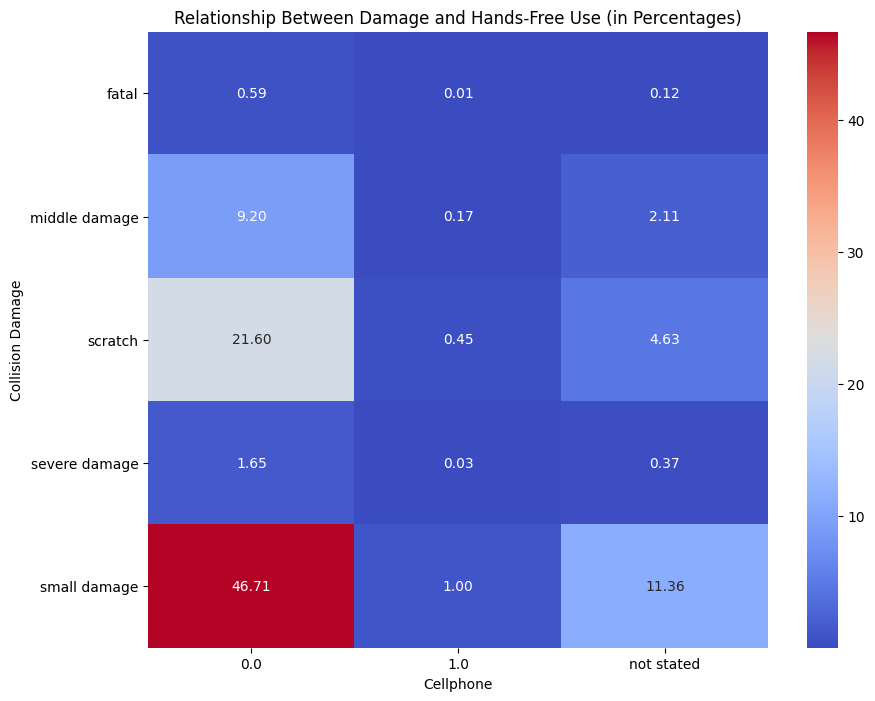

In [52]:
# Counting the occurrences of each combination of values
pivot_table = pd.crosstab(damage_cellphone['collision_damage'], damage_cellphone['cellphone_in_use'])

# Converting values to percentages
pivot_table_percent = pivot_table.div(pivot_table.sum().sum()) * 100

# Creating a heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(pivot_table_percent, annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title('Relationship Between Damage and Hands-Free Use (in Percentages)')
plt.xlabel('Cellphone')
plt.ylabel('Collision Damage')

ax.set_yticklabels(ax.get_yticklabels(), rotation=360)

plt.show()

**CONCLUSIONS:**  
- **Group without phone:** The majority of accidents (58.58%) are associated with minor damages, with fatal outcomes accounting for less than 1% (0.74%).  
- **Group with phone:** Despite using a phone, the distribution of damage types is similar to the group without a phone. The highest proportion is still minor damages (60.25%), with fatal outcomes around 0.70%.  
- **Group "not stated":** The percentage of fatal outcomes (0.67%) is almost the same as in other groups. Minor damages also dominate (61.11%).

- Regardless of whether a mobile phone was used, the majority of accidents are related to minor damages.  
- The share of accidents with severe consequences (fatalities, severe damage) does not differ significantly between drivers who use their phones and those who do not.  
- Information about mobile phone use does not always affect the distribution of damage types, suggesting that other significant factors may influence the severity of accidents.

**Conclusion:** Although mobile phone use while driving increases the likelihood of accidents, its impact on the type of damage (especially severity) is not as significant in the data.

#### 6. Evaluate the influence of weather conditions (WEATHER_1) on the severity of vehicle damage.

Assess the relationship between the severity of vehicle damage and weather conditions.

- **Analyze the data:** Use the **collisions** table (**collision_damage** field, **weather_1** field) to identify a possible correlation between damage severity and weather conditions.

- **Write an SQL query.**

- **Draw conclusions:** Based on the results, determine whether there is a statistically significant relationship between weather conditions and damage severity in collisions.

In [53]:
query = '''SELECT collision_damage,
                  weather_1
        FROM collisions'''
damage_weather= pd.read_sql(query, engine)

In [54]:
damage_weather.head()

,collision_damage,weather_1
0,small damage,cloudy
1,small damage,clear
2,scratch,clear
3,scratch,clear
4,scratch,clear


In [55]:
print(damage_weather['weather_1'].isna().sum())
print(damage_weather['weather_1'].unique())

7259
['cloudy' 'clear' 'raining' None 'fog' 'snowing' 'other' 'wind']


In [56]:
damage_weather['weather_1'] = damage_weather['weather_1'].fillna('not stated')
print(damage_weather['weather_1'].isna().sum())
print(damage_weather['weather_1'].unique())

0
['cloudy' 'clear' 'raining' 'not stated' 'fog' 'snowing' 'other' 'wind']


In [57]:
# Grouping by 'weather_1' and 'collision_damage', counting the number of cases
summary_table = damage_weather.groupby(['weather_1', 'collision_damage']).size().unstack(fill_value=0)

# Adding percentages for each row
summary_table_percent = round(summary_table.div(summary_table.sum(axis=1), axis=0) * 100, 2)

# Displaying the table with absolute values
print("Table with absolute values:")
print(summary_table)

Table with absolute values:
collision_damage  fatal  middle damage  scratch  severe damage  small damage
weather_1                                                                   
clear              8749         137013   278281          25375        671630
cloudy             1530          22176    49316           3949        126059
fog                 113            715     1219            208          3901
not stated           41            763     1766            140          4549
other                18            114      232             39          1113
raining             328           5528    14754            969         36397
snowing              10            227      431             52          1851
wind                  4             47      107             15           271


In [58]:
# Displaying the table with percentages
print("\nTable with percentages:")
print(summary_table_percent)


Table with percentages:
collision_damage  fatal  middle damage  scratch  severe damage  small damage
weather_1                                                                   
clear              0.78          12.22    24.82           2.26         59.91
cloudy             0.75          10.92    24.29           1.95         62.09
fog                1.84          11.61    19.80           3.38         63.37
not stated         0.56          10.51    24.33           1.93         62.67
other              1.19           7.52    15.30           2.57         73.42
raining            0.57           9.53    25.45           1.67         62.78
snowing            0.39           8.83    16.76           2.02         72.00
wind               0.90          10.59    24.10           3.38         61.04


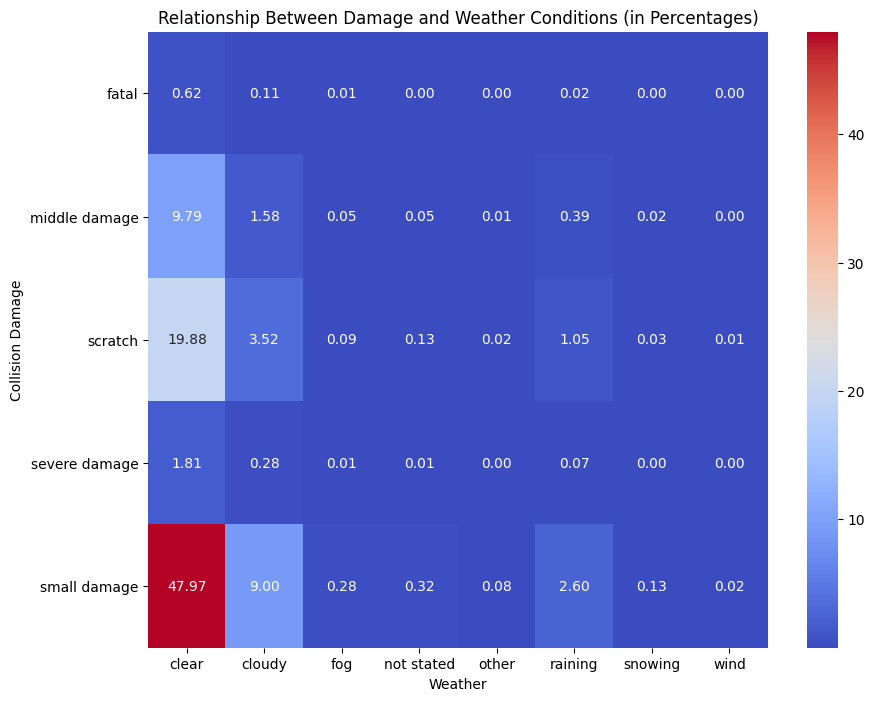

In [59]:
# Counting the occurrences of each combination of values
pivot_table = pd.crosstab(damage_weather['collision_damage'], damage_weather['weather_1'])

# Converting values to percentages
pivot_table_percent = pivot_table.div(pivot_table.sum().sum()) * 100

# Creating a heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(pivot_table_percent, annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title('Relationship Between Damage and Weather Conditions (in Percentages)')
plt.xlabel('Weather')
plt.ylabel('Collision Damage')

ax.set_yticklabels(ax.get_yticklabels(), rotation=360)

plt.show()

**CONCLUSIONS:**  
- **Clear and cloudy weather** are associated with the lowest percentages of fatalities and a predominance of minor damage.  
- **Fog, rain, and wind** lead to more severe consequences, reflected in higher percentages of fatalities and serious damage.  
- **Snow and fog** present higher risks compared to other weather conditions, especially in terms of serious accidents.  
These data can be useful for developing safety measures tailored to different weather conditions.

# Feature selection for building the model

### Model Based on Client's Vision  
- Create a model for predicting accidents (target variable — **at_fault**)  
- The type of culprit is only the car.  
- The accident resulted in any vehicle damage except for **SCRATCH**.  
- Data only for the year 2012.  
- The age of the vehicle is taken into account.

Displaying the data

In [60]:
# SQL query
query = '''SELECT 
    c.*,
    p.party_number,
    p.at_fault,
    p.insurance_premium,
    p.party_sobriety,
    p.party_drug_physical,
    p.cellphone_in_use,
    v.vehicle_type,
    v.vehicle_transmission,
    v.vehicle_age
FROM collisions c 
JOIN parties p ON c.case_id = p.case_id
JOIN vehicles v ON c.case_id = v.case_id AND p.party_number = v.party_number
WHERE p.party_type = 'car' 
  AND c.collision_damage != 'scratch' 
  AND EXTRACT(YEAR FROM c.collision_date) = 2012'''
data_1 = pd.read_sql(query, engine)

In [61]:
data_1.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,...,collision_time,party_number,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age
0,5600885,3607,san bernardino,400.0,north,0.0,clear,None,small damage,2,...,22:04:00,1,1,43.0,had not been drinking,None,0.0,sedan,auto,8.0
1,5449062,0708,contra costa,21.0,east,0.0,clear,None,small damage,2,...,02:00:00,2,0,54.0,had not been drinking,None,0.0,sedan,manual,10.0
2,5608728,0109,alameda,500.0,west,0.0,cloudy,highway,small damage,2,...,18:00:00,1,0,41.0,had not been drinking,None,0.0,sedan,auto,5.0
3,5608860,4303,santa clara,160.0,east,0.0,clear,None,small damage,2,...,11:32:00,2,0,28.0,had not been drinking,None,0.0,sedan,auto,0.0
4,5609619,1949,los angeles,16.0,east,0.0,cloudy,None,small damage,1,...,08:10:00,1,1,44.0,None,under drug influence,0.0,sedan,auto,1.0


In [62]:
data_1.shape

(56248, 29)

Filter and keep only the month of 2012

In [63]:
data_1['collision_date'] = pd.to_datetime(data_1['collision_date'], format='%Y-%m-%d')

In [64]:
data_1['collision_month'] = pd.to_datetime(data_1['collision_date']).dt.month
data_1['collision_month'].value_counts()

3     11511
4     10865
1     10789
2     10331
5      9683
6      1308
8       374
9       342
7       327
11      264
10      262
12      192
Name: collision_month, dtype: int64

**IMPORTANT POINT:**  
According to the task requirements, only data from the year 2012 should be used.  
It is important to note that the data appears incomplete — there is significantly more data for January to May compared to the other months.  
Therefore, this indicator cannot be considered when building the model.

Add the hour of the accident.

In [65]:
# Converting the 'collision_time' column to datetime type
data_1['collision_time'] = pd.to_datetime(data_1['collision_time'], format='%H:%M:%S')

# Creating a new column with the hour of the accident
data_1['collision_hour'] = data_1['collision_time'].dt.hour
data_1['collision_hour'].value_counts()

15.0    4868
17.0    4250
16.0    4153
14.0    4108
18.0    3695
13.0    3589
12.0    3328
11.0    2873
19.0    2565
7.0     2545
8.0     2515
10.0    2304
20.0    2160
9.0     2018
21.0    1881
22.0    1551
23.0    1374
2.0     1177
1.0     1139
6.0     1113
0.0     1062
3.0      708
5.0      683
4.0      501
Name: collision_hour, dtype: int64

Checking for duplicates

In [66]:
data_1[data_1[['case_id','party_number']].duplicated(keep=False)]

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,...,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,collision_month,collision_hour


No duplicates found.

#### Primary selection of factors.

Let's consider for model construction only those factors that, in our view, have an impact on traffic accidents.

**Collisions Table**
- 'county_location' – the region might have an impact.
- 'weather_1' – Weather conditions may affect road traction and visibility.
- 'road_surface' – Road surface condition may impact vehicle handling.
- 'road_condition_1' – Road condition may affect vehicle handling.
- 'lighting' – Lighting conditions may influence visibility.
- 'collision_hour' – The time of the incident might have an impact.

**Parties Table**
- 'at_fault' – Fault of the participant – target feature.
- 'cellphone_in_use' – Presence of a phone in the vehicle (ability to talk via hands-free) – may affect concentration.

**Vehicles Table**
- 'vehicle_age' – Age of the vehicle in years – may influence based on maintenance, repairs, and mileage.
- 'vehicle_type' – Type of body – may influence, as passenger cars are more maneuverable, but drivers might be less cautious due to a sense of increased safety. The likelihood of involvement in minor accidents may be higher.
- 'vehicle_transmission' – Type of transmission – may influence, as the driver needs to pay more attention to shifting gears in a manual transmission, which could increase the risk of making a mistake in a critical situation.

In [67]:
data_2 = data_1.copy()

In [68]:
data_1.drop(['case_id', 'county_city_location', 'direction', 'distance', 'intersection',
             'location_type', 'collision_damage', 'party_count', 'primary_collision_factor', 
             'pcf_violation_category', 'type_of_collision', 'motor_vehicle_involved_with', 
             'party_number', 'insurance_premium', 'control_device',
             'collision_date', 'collision_time', 'party_drug_physical', 
             'party_sobriety', 'collision_month'], axis=1, inplace=True)

In [69]:
data_1.head()

,county_location,weather_1,road_surface,road_condition_1,lighting,at_fault,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,collision_hour
0,san bernardino,clear,dry,normal,dark with street lights,1,0.0,sedan,auto,8.0,22.0
1,contra costa,clear,dry,normal,dark with street lights,0,0.0,sedan,manual,10.0,2.0
2,alameda,cloudy,dry,normal,dusk or dawn,0,0.0,sedan,auto,5.0,18.0
3,santa clara,clear,dry,normal,daylight,0,0.0,sedan,auto,0.0,11.0
4,los angeles,cloudy,dry,normal,daylight,1,0.0,sedan,auto,1.0,8.0


#### Data preprocessing

In [70]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_location       56248 non-null  object 
 1   weather_1             56080 non-null  object 
 2   road_surface          55900 non-null  object 
 3   road_condition_1      55999 non-null  object 
 4   lighting              56094 non-null  object 
 5   at_fault              56248 non-null  int64  
 6   cellphone_in_use      51777 non-null  float64
 7   vehicle_type          56248 non-null  object 
 8   vehicle_transmission  55389 non-null  object 
 9   vehicle_age           54554 non-null  float64
 10  collision_hour        56160 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.7+ MB


We will remove the rows with missing values in the vehicle age, as there is no data to fill them in, and the client considers this parameter important.

In [71]:
data_1 = data_1[data_1['vehicle_age'].notna()]

#### Imputing missing values

In [72]:
data_1.isna().sum()

county_location            0
weather_1                165
road_surface             329
road_condition_1         237
lighting                 152
at_fault                   0
cellphone_in_use        4170
vehicle_type               0
vehicle_transmission     575
vehicle_age                0
collision_hour            84
dtype: int64

In [73]:
for column in data_1.columns:
    # Let's check the dimensions of the column.
    column_dim = data_1[column].ndim
    
    if column_dim == 1:
        print(f'The column "{column}" is one-dimensional.')
        unique_values = data_1[column].unique()
        num_unique = len(unique_values)
        print(f'Unique values in the column "{column}" (total {num_unique}):')
        print(unique_values)
    else:
        print(f'The column "{column}" has a dimension of {column_dim}, it is not one-dimensional.')
    print()

The column "county_location" is one-dimensional.
Unique values in the column "county_location" (total 58):
['san bernardino' 'contra costa' 'alameda' 'santa clara' 'los angeles'
 'orange' 'san mateo' 'san joaquin' 'sacramento' 'sonoma' 'san diego'
 'yolo' 'ventura' 'sutter' 'kern' 'riverside' 'tuolumne' 'placer'
 'el dorado' 'stanislaus' 'santa barbara' 'inyo' 'san luis obispo' 'marin'
 'san francisco' 'monterey' 'solano' 'shasta' 'tulare' 'humboldt' 'tehama'
 'santa cruz' 'nevada' 'calaveras' 'fresno' 'del norte' 'modoc' 'yuba'
 'lake' 'colusa' 'napa' 'madera' 'mendocino' 'plumas' 'merced' 'butte'
 'amador' 'trinity' 'siskiyou' 'sierra' 'san benito' 'imperial' 'glenn'
 'kings' 'mariposa' 'lassen' 'mono' 'alpine']

The column "weather_1" is one-dimensional.
Unique values in the column "weather_1" (total 8):
['clear' 'cloudy' None 'raining' 'snowing' 'fog' 'other' 'wind']

The column "road_surface" is one-dimensional.
Unique values in the column "road_surface" (total 5):
['dry' 'wet' 's

The missing values imputation

In [74]:
data_1.loc[(data_1['road_surface'] == 'dry') & (data_1['weather_1'].isna()), 'weather_1'] = 'clear'
data_1.loc[(data_1['road_surface'] == 'snowy') & (data_1['weather_1'].isna()), 'weather_1'] = 'snowing'
data_1.loc[(data_1['road_surface'] == 'wet') & (data_1['weather_1'].isna()), 'weather_1'] = 'raining'

In [75]:
data_1.loc[(data_1['weather_1'] == 'clear') & (data_1['road_surface'].isna()), 'road_surface'] = 'dry'
data_1.loc[(data_1['weather_1'] == 'raining') & (data_1['road_surface'].isna()), 'road_surface'] = 'wet'

We will remove the column `road_surface` as it duplicates the data in `weather_1`.

In [76]:
data_1.drop('road_surface', axis=1, inplace=True)

We will remove the column `vehicle_type` as it contains only two values, which are not a significant factor influencing traffic accidents, since sedan and coupe are both types of passenger cars and are virtually identical.

In [77]:
data_1.drop('vehicle_type', axis=1, inplace=True)

We will impute the `cellphone_in_use` column – we will assume that if the possibility to talk via the car is not explicitly indicated, it means it is absent.

In [78]:
data_1['cellphone_in_use'] = data_1['cellphone_in_use'].fillna(0.0)       

We will impute the `lighting` column – if the lighting is not working, it is equivalent to no lighting at all.

In [79]:
data_1['lighting'] = data_1['lighting'].replace('dark with street lights not functioning', 'dark with no street lights')

We will impute the missing values in the `collision_hour` column based on the `lighting` column.

In [80]:
data_1.loc[(data_1['lighting'] == 'dark with street lights') & (data_1['collision_hour'].isna()), 'collision_hour'] = 17.0
data_1.loc[(data_1['lighting'] == 'daylight') & (data_1['collision_hour'].isna()), 'collision_hour'] = 13.0
data_1.loc[(data_1['lighting'] == 'dark with no street lights') & (data_1['collision_hour'].isna()), 'collision_hour'] = 22.0
data_1.loc[(data_1['lighting'] == 'dusk or dawn') & (data_1['collision_hour'].isna()), 'collision_hour'] = 4.0

Since there is a direct relationship between the time of day and road lighting, we will remove the data on lighting to avoid multicollinearity.

In [81]:
data_1.drop('lighting', axis=1, inplace=True)

In [82]:
data_1.isna().sum()

county_location           0
weather_1                61
road_condition_1        237
at_fault                  0
cellphone_in_use          0
vehicle_transmission    575
vehicle_age               0
collision_hour            3
dtype: int64

Change the data type.

In [83]:
data_1['at_fault'] = data_1['at_fault'].astype('object')
data_1['cellphone_in_use'] = data_1['cellphone_in_use'].astype('object') 

In [84]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54554 entries, 0 to 56247
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_location       54554 non-null  object 
 1   weather_1             54493 non-null  object 
 2   road_condition_1      54317 non-null  object 
 3   at_fault              54554 non-null  object 
 4   cellphone_in_use      54554 non-null  object 
 5   vehicle_transmission  53979 non-null  object 
 6   vehicle_age           54554 non-null  float64
 7   collision_hour        54551 non-null  float64
dtypes: float64(2), object(6)
memory usage: 3.7+ MB


#### Exploratory Data Analysis (EDA)

##### Quantitative features.

Let's examine the distribution of the quantitative features. We have only two: hour and vehicle age.

,collision_hour,vehicle_age
count,54551.000000,54554.000000
mean,13.312808,4.856472
std,5.532632,3.234503
min,0.000000,0.000000
25%,10.000000,3.000000
50%,14.000000,4.000000
75%,17.000000,7.000000
max,23.000000,161.000000


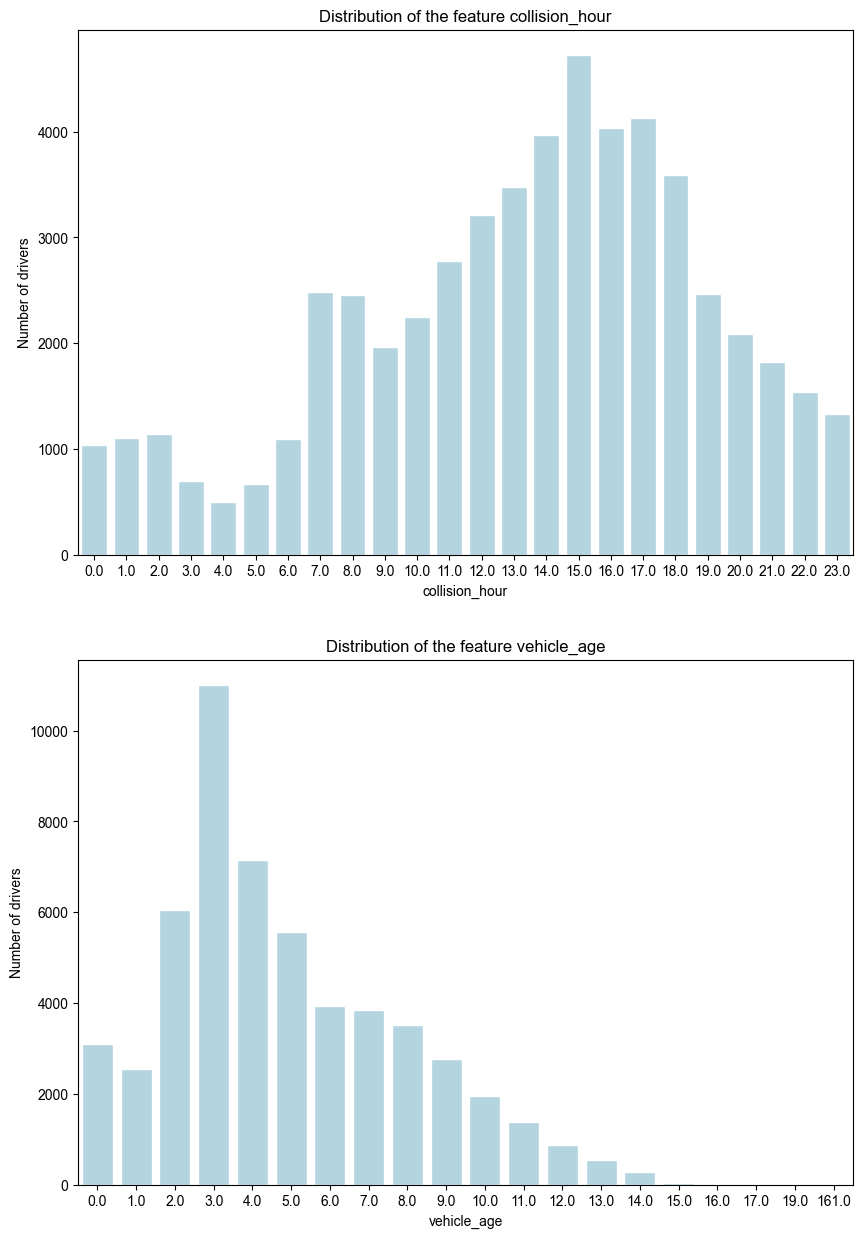

In [85]:
simplefilter(action='ignore', category=FutureWarning)

num_cols = ['collision_hour', 'vehicle_age']
display(data_1[num_cols].describe())
i=0
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,15))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
axe = axes.ravel()
for col in num_cols:
    sns.set_style('whitegrid')
    sns.countplot(data_1[col], color='lightblue', ax=axe[i])
    axe[i].set_title(f'Distribution of the feature {col}')
    axe[i].set_xlabel(col)
    axe[i].set_ylabel('Number of drivers')
    i+=1

- In the distribution of accidents by hour, there are two peaks at the beginning and end of the workday. This makes sense, as the roads are most congested during these times.
- The majority of vehicles in the dataset are 3 years old.
- In the age distribution, there is an anomalous vehicle age of 161 years, which we have seen previously. We will replace it with 13 years in the training dataset (assuming the vehicle age was given in months).

Let's analyze how the values of the quantitative features affect the target variable `at_fault`.

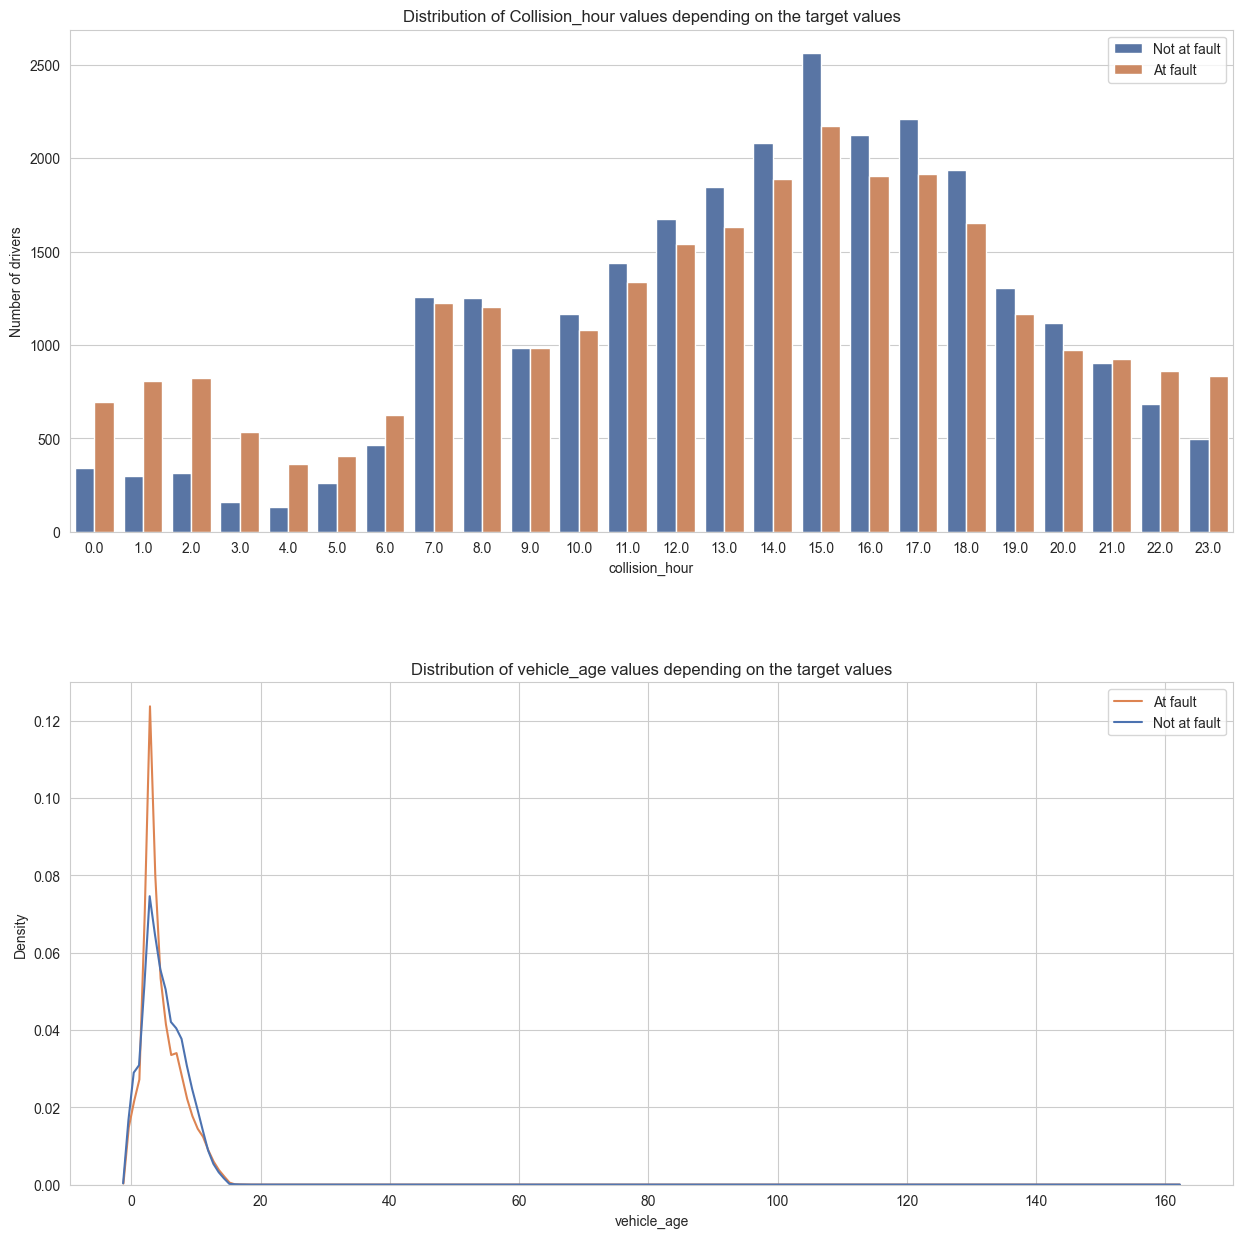

In [86]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,15))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
axe = axes.ravel()
i=0
cols = ['collision_hour']
for col in cols:
    sns.countplot(x = col, hue = 'at_fault', palette='deep', data = data_1, orient='h', ax=axe[i])
    axe[i].set_title(f'Distribution of {col.capitalize()} values depending on the target values')
    axe[i].set_ylabel('Number of drivers')
    axe[i].legend(['Not at fault', 'At fault'])
    i+=1
sns.kdeplot(x = 'vehicle_age', hue = 'at_fault', palette='deep', data = data_1, ax=axe[i])
axe[i].set_title(f'Distribution of vehicle_age values depending on the target values')
axe[i].set_ylabel('Density')
axe[i].legend(['At fault', 'Not at fault'])   
None

**Conclusion**:

There are more at-fault drivers during the night and morning hours, possibly due to fatigue or driving under the influence.

Additionally, owners of vehicles aged 1-4 years are more often at fault, which could be related to the drivers' experience or factory defects in the cars.

##### Categorical features

We have quite a few categorical features. Let's examine their distribution in relation to the target variable, so we can immediately observe both the distribution of categories and their influence on the target feature. We will analyze the vehicle usage area separately, as it contains many unique categories.

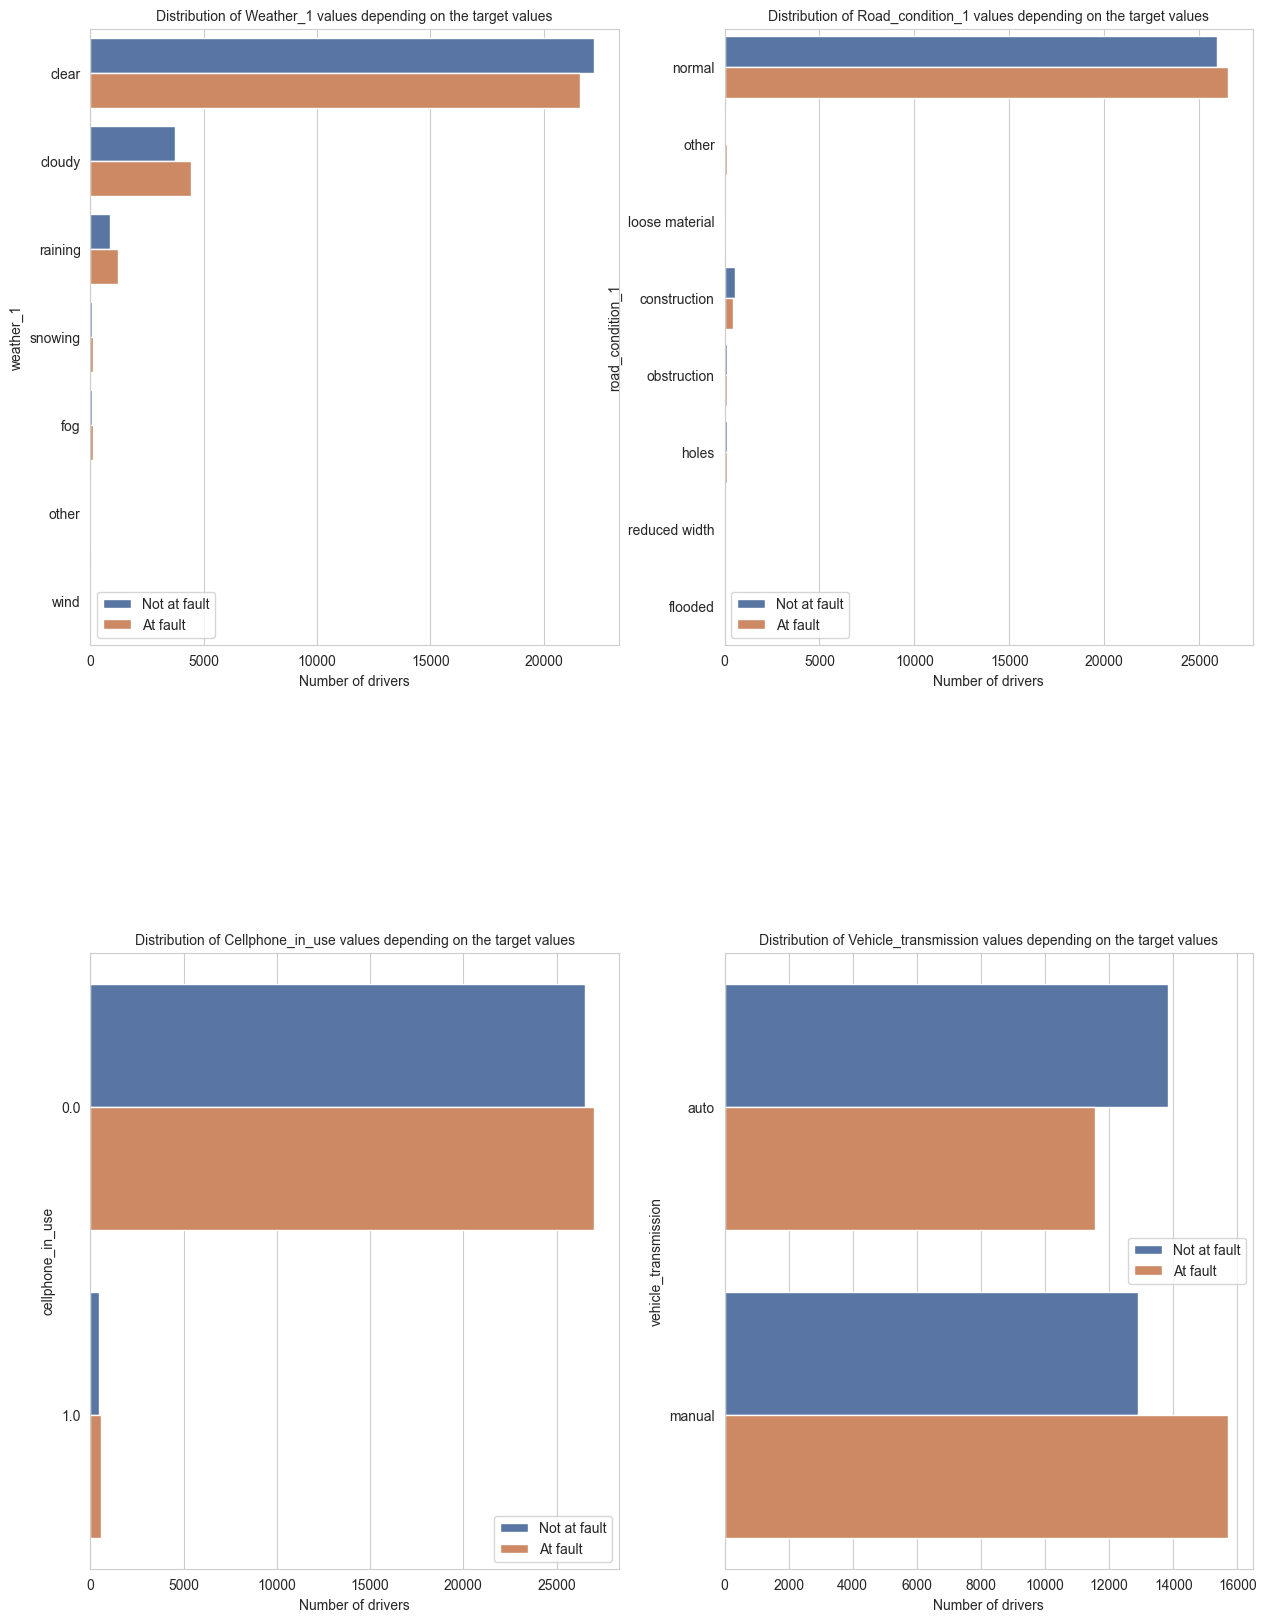

In [87]:
cat_cols = ['weather_1', 'road_condition_1', 'cellphone_in_use',
           'vehicle_transmission']
plt.rc('font', size=10)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,20))
plt.subplots_adjust(wspace=0.2, hspace=0.5)
axe = axes.ravel()
i=0
for col in cat_cols:
    sns.countplot(y = col, hue = 'at_fault', data = data_1, palette='deep', orient='h', ax=axe[i])
    axe[i].set_title(f'Distribution of {col.capitalize()} values depending on the target values', fontsize=10)
    axe[i].set_xlabel('Number of drivers')
    axe[i].legend(['Not at fault', 'At fault'])
    i+=1

**Conclusion**:
- Drivers are more likely to be at fault in rainy and cloudy weather than in good weather.
- The `Road_condition1` feature is highly imbalanced. The majority of values correspond to normal road conditions, where the number of at-fault drivers is the highest, while other categories are sparse.
- Drivers using vehicles with manual transmissions are more likely to be at fault.
- People who use their phones while driving are more often at fault in accidents.

Let's now analyze the vehicle usage area. Since there are many unique categories in this feature, we'll display only the top 15 by the number of accidents.

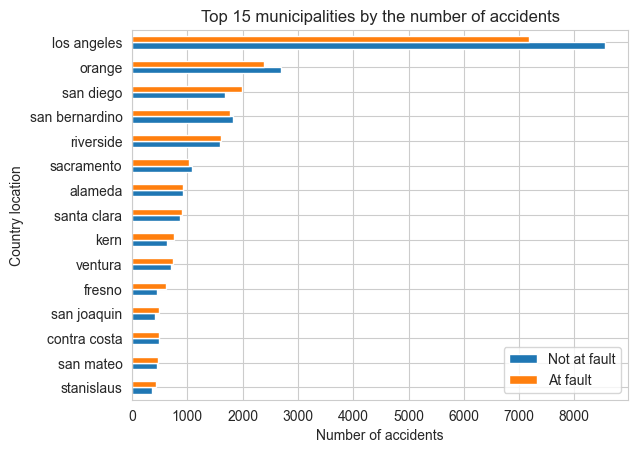

In [88]:
big_cat = data_1['county_location'].value_counts(ascending=False).head(15).reset_index()['index'].unique()
graf_data = pd.DataFrame({'Not at fault': data_1[(data_1['at_fault']==0) & (data_1['county_location'].isin(big_cat))]['county_location'] \
                          .value_counts(ascending=False).head(15),
                          'At fault': data_1[(data_1['at_fault']==1) & (data_1['county_location'].isin(big_cat))]['county_location'] \
                          .value_counts(ascending=False).head(15)})
graf_data.sort_values(by='At fault', ascending=True, inplace=True)
graf_data.plot.barh(title='Top 15 municipalities by the number of accidents',  grid=True, rot=0)
plt.ylabel('Country location')
plt.xlabel('Number of accidents')
plt.show()
None

**Conclusion**:  
The graph shows that for some municipalities with the highest number of accidents, the number of at-fault drivers exceeds the number of drivers not at fault. At the same time, in other areas, the proportion of careful drivers is higher. Therefore, this feature can be used in the model.

Let's now take a look at how the values of the target variable `at_fault` are distributed.

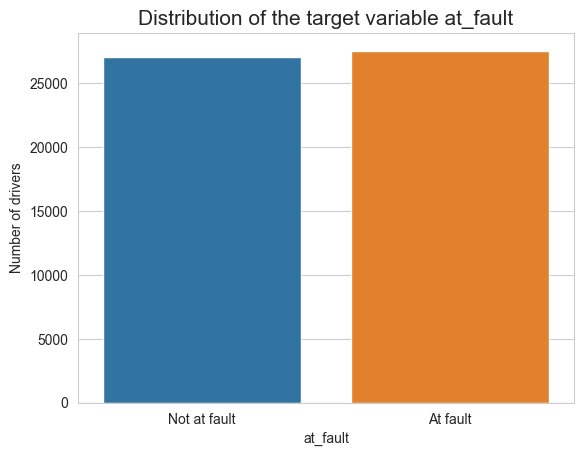

In [89]:
sns.countplot(x = 'at_fault', data = data_1)
plt.title('Distribution of the target variable at_fault', fontsize=15)
plt.xlabel('at_fault')
plt.xticks([0, 1], ['Not at fault', 'At fault'])
plt.ylabel('Number of drivers')
None

In the dataset, the total number of at-fault drivers is slightly higher than the number of drivers not at fault, but the proportions are approximately the same. This is good as there is no significant imbalance in the data.

#### Correlation matrix.

We will build a correlation matrix to determine the strength of the relationships between the features. Since our target variable is categorical, we will use the Phi-k coefficient. To build the matrix, we will remove outliers based on the vehicle age.

In [90]:
data_clean = data_1
data_clean .loc[data_clean['vehicle_age'] == 161, 'vehicle_age'] = 13

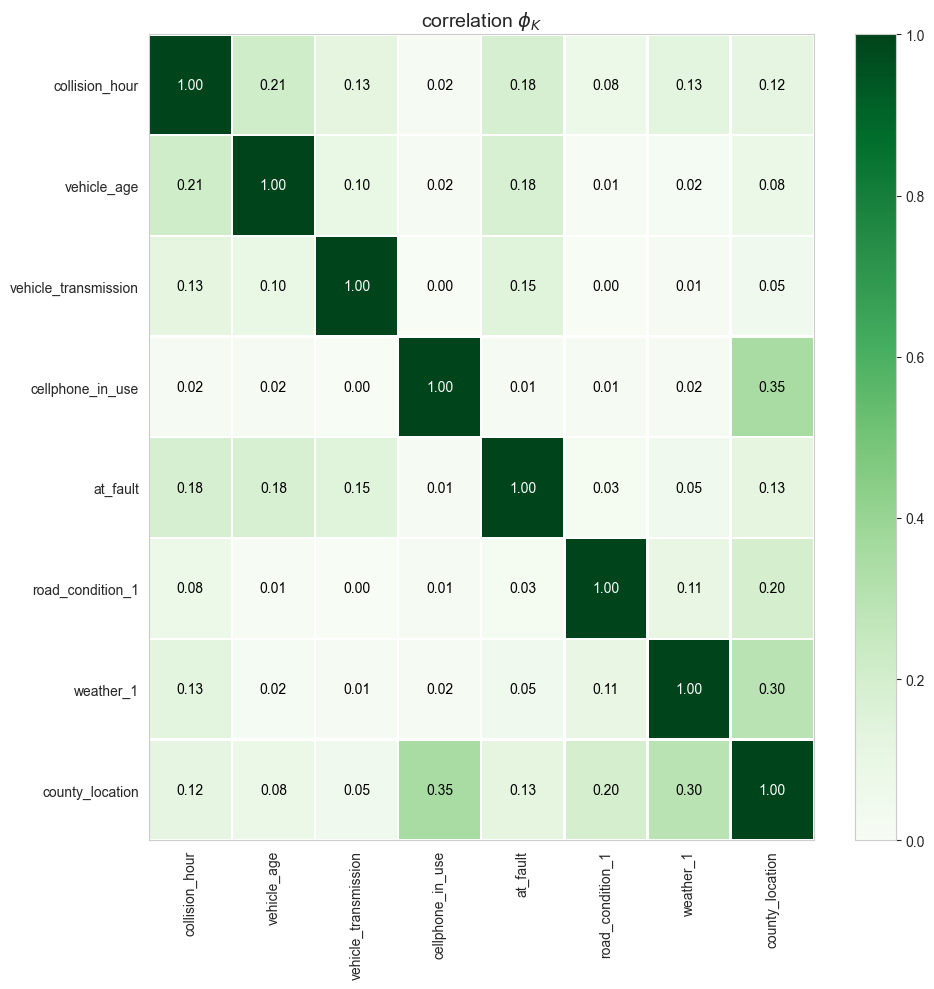

In [91]:
interval_cols = ['vehicle_age']

phik_overview = data_clean .phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        color_map='Greens', 
                        title=r'correlation $\phi_K$', 
                        fontsize_factor=1,
                        figsize=(10,10))
plt.tight_layout()

**Conclusion**:  
Based on the obtained data and the correlation matrix, we can conclude that the following features influence the target variable (at_fault):

- 'collision_hour' – time of the accident
- 'vehicle_age' – age of the vehicle
- 'vehicle_transmission' – type of transmission
- 'county_location' – location of the accident

In [92]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54554 entries, 0 to 56247
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_location       54554 non-null  object 
 1   weather_1             54493 non-null  object 
 2   road_condition_1      54317 non-null  object 
 3   at_fault              54554 non-null  object 
 4   cellphone_in_use      54554 non-null  object 
 5   vehicle_transmission  53979 non-null  object 
 6   vehicle_age           54554 non-null  float64
 7   collision_hour        54551 non-null  float64
dtypes: float64(2), object(6)
memory usage: 5.8+ MB


The final dataset consists of 7 input features.

#### Split the data into training and testing sets.

In [93]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    data_1.drop(columns=['at_fault']),
    data_1['at_fault'],
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=data_1['at_fault']
)


y_train = y_train.astype(int)
y_test = y_test.astype(int)

We will treat the vehicle age of 161 years as 161 months

In [94]:
X_train.loc[X_train['vehicle_age'] == 161, 'vehicle_age'] = 13

**Conclusion**:

As a result of processing and filtering the original database, a dataset was created containing 56,248 rows and 8 columns, based on information about accident participants for which there is data on the circumstances of the incidents and vehicles. The vehicle age feature was considered according to the client's requirements, and 3% of the data was deleted for records with missing values for this feature, as there was no logical way to impute the missing values. Several missing values in other features were imputed based on the logic of the data.

Correlation analysis between features showed weak relationships, with correlation coefficients ranging from 0.01 to 0.18, indicating a low linear dependency between variables, but not excluding the possibility of nonlinear dependencies. The dataset was split into training and testing sets in a 70%/30% ratio.

### Model creation for accident probability estimation. Selection of the best model.

#### Selection of the metric.

In this task, the primary goal of the system is to warn the driver about the high risk of an accident, i.e., when the probability of "at_fault" equals 1 (the driver is at fault). Therefore, an important aspect is the accuracy of warnings in high-risk situations, as well as minimizing false alarms (when the system warns of a high risk, but no accident will actually occur).

**To evaluate the model, we can consider several metrics:**

- **Precision** – will show how accurately the system predicts that the driver will be at fault in the accident while minimizing false positives. This metric is important when the goal is to avoid excessive unnecessary warnings.

- **Recall** – will show how effectively the system identifies all instances when the driver will be at fault. A high recall means the system alerts the driver whenever it’s truly needed.

- **F1-Score** – a balanced metric that considers both precision and recall. It is important to use it when both prediction accuracy and the ability to identify all high-risk cases are equally important.

- **ROC-AUC (Area Under the ROC Curve)** – this metric helps evaluate how well the model distinguishes between the "at fault" and "not at fault" classes across the entire range of thresholds. In this task, it could be useful if it's important to adjust the decision threshold for risk depending on the conditions (e.g., driver preferences).

**Recommended metric:** In this business problem, the balance between precision and recall is crucial (to warn about risk without over-warned and with minimal missed accident cases), so we will use the F1-Score. This will help avoid bias toward false positives or missing critical risk situations. Recall will also be calculated immediately so we can see how the model performs in detecting at-fault drivers.

We will compare the results of all models and select the best one based on the F1 and recall values.

#### DummyClassifier

We will build a model that predicts the outcome when the probability of being at fault or not at fault in an accident is equal. This model will serve as a benchmark to understand whether the other models are necessary. If the metrics of the other models do not outperform this simple model, we can just predict the average value. 

In [95]:
cat_columns = ['weather_1', 'road_condition_1', 'cellphone_in_use', 'vehicle_transmission', 'county_location']
num_columns = ['collision_hour', 'vehicle_age']

cat_pipe = Pipeline([('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('ohe', OneHotEncoder(drop='first', handle_unknown='error'))])

num_pipe = Pipeline([('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('num', StandardScaler())])

data_preprocessor = ColumnTransformer(
    [('ohe', cat_pipe, cat_columns),
     ('num', num_pipe, num_columns)], remainder='passthrough')

dummy = Pipeline([('preprocessor', data_preprocessor),
                  ('models', DummyClassifier(random_state=RANDOM_STATE, strategy='uniform'))])

dummy.fit(X_train, y_train)
preds = dummy.predict(X_test)

dummy_f1 = round(f1_score(y_test, preds),2)
dummy_recall = round(recall_score(y_test, preds),2)

print('Dummy F1-Score value: ', dummy_f1)
print('Dummy Recall value: ', dummy_recall)

Dummy F1-Score value:  0.5
Dummy Recall value:  0.49


In [96]:
table = pd.DataFrame([['DummyClassifier', 'strategy=uniform', dummy_f1, dummy_recall]],
                    columns=['Model', 'Params', 'F1 Score', 'Recall Score'])
table

,Model,Params,F1 Score,Recall Score
0,DummyClassifier,strategy=uniform,0.5,0.49


**Conclusion**:

The baseline metric values have been obtained – they correspond to a prediction where each class has an equal probability.

#### DecisionTreeClassifier

In [97]:
simplefilter(action='ignore', category=UserWarning)

cat_columns = ['county_location',
             'weather_1',
             'road_condition_1',
             'cellphone_in_use',
             'vehicle_transmission']
num_columns = ['vehicle_age', 'collision_hour']


cat_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)) 
    ]
)

num_pipe = Pipeline(
    [
        ('imputer_num', SimpleImputer(missing_values=np.nan, strategy='median')), 
        ('num', StandardScaler())
    ]
)

In [98]:
data_preprocessor = ColumnTransformer(
    [('cat', cat_pipe, cat_columns),
     ('num', num_pipe, num_columns)], 
    remainder='passthrough')

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])

# Получение количества признаков после обработки
n_features = X_train.shape[1]  # Количество признаков до препроцессинга


param_grid = {
    'models__max_depth': range(1, 20),
    'models__max_features': range(1, n_features + 1),  # Максимальное количество признаков
    'models__min_samples_leaf': range(1, 20)
}

dt = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=['f1', 'recall'],
    refit = 'f1',
    random_state=42,
    n_jobs=-1)

In [99]:
%time
dt.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=nan))]),
                                                                               ['county_location',


In [100]:
best_params_dt = dt.best_params_
f1_train_dt = round(dt.best_score_, 2)
recall_train_dt = round(dt.cv_results_['mean_test_recall'][dt.best_index_], 2)

print("Best parameters DecisionTreeClassifier: ", best_params_dt)
print("Best f1 DecisionTreeClassifier train: ", f1_train_dt)
print('Recall DecisionTreeClassifier train:', recall_train_dt)

Best parameters DecisionTreeClassifier:  {'models__min_samples_leaf': 6, 'models__max_features': 4, 'models__max_depth': 7}
Best f1 DecisionTreeClassifier train:  0.57
Recall DecisionTreeClassifier train: 0.56


In [101]:
table.loc[len(table.index )] = ['DecisionTreeClassifier', best_params_dt, f1_train_dt, recall_train_dt]
table

,Model,Params,F1 Score,Recall Score
0,DummyClassifier,strategy=uniform,0.50,0.49
1,DecisionTreeClassifier,"{'models__min_samples_leaf': 6, 'models__max_f...",0.57,0.56


**Conclusion**:

**Best parameters:**

- `models__min_samples_leaf: 11` — this is the minimum number of samples in a leaf of the decision tree, which helps prevent overfitting by ensuring the model is not too deep or overly complex.
- `models__max_features: 4` — this is the number of features the model considers at each split, which helps improve predictive power by limiting the number of features that can be used at each node.
- `models__max_depth: 4` — the maximum depth of the tree, which helps increase its flexibility to capture complex relationships in the data.

**Quality metrics:**

- F1-score on the training set: 0.57 — this is a balanced metric that takes both recall and precision into account. A value of 0.57 indicates a moderate balance between these metrics, which is acceptable for this model.
- Recall on the training set: 0.59 — this is a measure of completeness, showing that the model identifies 59% of all positive examples, which is a satisfactory result for this task.

#### RandomForestClassifier

In [102]:
RANDOM_STATE = 42

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data_1.drop(columns=['at_fault']),
    data_1['at_fault'],  # целевой признак
    test_size=0.3, random_state=RANDOM_STATE,
    stratify=data_1['at_fault']
)

X_train.loc[X_train['vehicle_age'] == 161, 'vehicle_age'] = 13

# Convert the target feature to int
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Categorical features
categorical_columns = ['county_location',
             'weather_1',
             'road_condition_1',
             'cellphone_in_use',
             'vehicle_transmission']

# Numeric columns
num_columns = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()


# Pipeline for categorical data using OrdinalEncoder
categorical_pipeline = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)) 
    ]
)

# Pipeline for numeric data
numeric_pipeline = Pipeline(
    [
        ('imputer_num', SimpleImputer(missing_values=np.nan, strategy='median')), 
        ('scaler', StandardScaler())
    ]
)


# ColumnTransformer for combined data processing
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, num_columns),
    ('cat', categorical_pipeline, categorical_columns)
])


# Define parameters for RandomizedSearchCV
params = {
    'classifier__n_estimators': [10, 20, 30, 100],
    'classifier__max_depth': [1, 3, 6, 10]
}

# Pipeline for model training
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

# RandomizedSearchCV for hyperparameter optimization
rf = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=params,
    cv=5,
    scoring=['f1', 'recall'],
    refit='f1',
    random_state=42,
    n_jobs=-1
)

# Running the search for best parameters
rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer_num',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['vehicle_age',
                                                                                'collision_hour']),
                                                                              ('cat',
                                                                               Pi

In [103]:
# Getting the best parameters and metrics
best_params_rf = rf.best_params_
f1_train_rf = round(rf.best_score_, 2)
recall_train_rf = round(rf.cv_results_['mean_test_recall'][rf.best_index_], 2)

print("Best parameters RandomForestClassifier found: ", best_params_rf)
print(f'RandomForestClassifier - F1 train Score: {f1_train_rf}')
print(f'RandomForestClassifier - Recall train Score: {recall_train_rf}')

Best parameters RandomForestClassifier found:  {'classifier__n_estimators': 100, 'classifier__max_depth': 6}
RandomForestClassifier - F1 train Score: 0.58
RandomForestClassifier - Recall train Score: 0.55


In [104]:
table.loc[len(table.index )] = ['RandomForestClassifier', best_params_rf, f1_train_rf, recall_train_rf]
table

,Model,Params,F1 Score,Recall Score
0,DummyClassifier,strategy=uniform,0.50,0.49
1,DecisionTreeClassifier,"{'models__min_samples_leaf': 6, 'models__max_f...",0.57,0.56
2,RandomForestClassifier,"{'classifier__n_estimators': 100, 'classifier_...",0.58,0.55


**Best Parameters:**

- n_estimators: 10 – This is the number of trees.
- max_depth: 6 – The maximum depth of the tree.

**Best F1 Score on cross-validation:**

The F1 Score on cross-validation was 0.57. F1 Score is the harmonic mean of precision and recall, which makes it suitable for imbalanced data. A value of 0.57 indicates a balance between these two metrics; however, it is below 1, meaning the model still makes some errors.

**Recall on training data:**

The Recall on training data was 0.56. This indicates that the model correctly identified approximately 57% of all true positive examples. If this value significantly differs from Recall on the test data, it may indicate overfitting or underfitting.

**Conclusion:**
The current parameters provide a moderate result.

#### CatBoost

In [105]:
RANDOM_STATE = 42

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data_1.drop(columns=['at_fault']),
    data_1['at_fault'],  # целевой признак
    test_size=0.3, random_state=RANDOM_STATE,
    stratify=data_1['at_fault']
)

# Converting categorical features to strings
categorical_columns = ['county_location',
             'weather_1',
             'road_condition_1',
              'cellphone_in_use',
             'vehicle_transmission']

# Converting categorical features to strings for X_train and X_test
X_train[categorical_columns] = X_train[categorical_columns].astype(str)
X_test[categorical_columns] = X_test[categorical_columns].astype(str)
    
X_train.loc[X_train['vehicle_age'] == 161, 'vehicle_age'] = 13


# Converting the target feature to int
y_train = y_train.astype(int)
y_test = y_test.astype(int)


# Defining hyperparameters for search
params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.001, 0.01, 0.1],
    'depth': [4, 6, 8, 10]  
}


# Creating the CatBoostClassifier model
model_cat = CatBoostClassifier(
    cat_features=categorical_columns,  # Categorical features
    random_seed=RANDOM_STATE,
    verbose=False  # Disable progress output
)

cat = RandomizedSearchCV(
    model_cat,
    param_distributions=params,
    cv=5,
    scoring=['f1', 'recall'],
    refit='f1',
    random_state=42,
    n_jobs=-1
)


# Running the search for best hyperparameters
cat.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x000002158614A3D0>,
                   n_jobs=-1,
                   param_distributions={'depth': [4, 6, 8, 10],
                                        'learning_rate': [0.001, 0.01, 0.1],
                                        'n_estimators': [50, 100, 150]},
                   random_state=42, refit='f1', scoring=['f1', 'recall'])

In [106]:
best_params_cat = cat.best_params_
f1_train_cat = round(cat.best_score_, 2)
recall_train_cat = round(cat.cv_results_['mean_test_recall'][cat.best_index_], 2)

print("Best parameters found: ", best_params_cat)
print(f'CatBoost - F1 train Score: {f1_train_cat}')
print(f'CatBoost - Recall train Score: {recall_train_cat}')

Best parameters found:  {'n_estimators': 150, 'learning_rate': 0.1, 'depth': 4}
CatBoost - F1 train Score: 0.58
CatBoost - Recall train Score: 0.56


In [107]:
table.loc[len(table.index )] = ['CatBoostClassifier', best_params_cat, f1_train_cat, recall_train_cat]
table

,Model,Params,F1 Score,Recall Score
0,DummyClassifier,strategy=uniform,0.50,0.49
1,DecisionTreeClassifier,"{'models__min_samples_leaf': 6, 'models__max_f...",0.57,0.56
2,RandomForestClassifier,"{'classifier__n_estimators': 100, 'classifier_...",0.58,0.55
3,CatBoostClassifier,"{'n_estimators': 150, 'learning_rate': 0.1, 'd...",0.58,0.56


**Conclusion**:

**The parameters for the CatBoost model:**

- n_estimators (Number of trees): 150
- learning_rate (Learning rate): 0.1
- depth (Tree depth): 6

**Model evaluation on the training set:**

- F1 Score: 0.58
- Recall: 0.56

**Interpretation of results:**

- F1 Score measures the balance between precision and recall, where a value of 0.58 indicates that the model is fairly balanced.

- Recall indicates how well the model identifies positive cases. With a result of 0.56, we can conclude that the model misses some positive cases.

These parameters provide moderate results.

#### LightGBM

Let's change the strategy for encoding categorical features. In boosting, there is an internal encoder, so we will use it.

First, we will impute missing values and scale numerical features using StandardScaler, and also change the data type of the columns with categorical features to category.

In [108]:
train_columns = X_train.columns
test_columns = X_test.columns

imputer = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

X_train = pd.DataFrame(X_train_imp, columns = train_columns)
X_test = pd.DataFrame(X_test_imp, columns = test_columns)

num_cols = ['collision_hour', 'vehicle_age']
cat_cols = ['weather_1', 'county_location', 'road_condition_1', 'cellphone_in_use', 'vehicle_transmission']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_cols)

X_train = pd.concat([X_train_scaled, X_train[cat_cols]], axis=1)
X_test = pd.concat([X_test_scaled, X_test[cat_cols]], axis=1)

for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38187 entries, 0 to 38186
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   collision_hour        38187 non-null  float64 
 1   vehicle_age           38187 non-null  float64 
 2   weather_1             38187 non-null  category
 3   county_location       38187 non-null  category
 4   road_condition_1      38187 non-null  category
 5   cellphone_in_use      38187 non-null  category
 6   vehicle_transmission  38187 non-null  category
dtypes: category(5), float64(2)
memory usage: 786.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16367 entries, 0 to 16366
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   collision_hour        16367 non-null  float64 
 1   vehicle_age           16367 non-null  float64 
 2   weather_1             16367 non-null  category
 

In [109]:
model = LGBMClassifier(random_state = RANDOM_STATE, objective = 'binary')
param_grid = [
    {'n_estimators': [50, 100, 150],
     'learning_rate': [0.001, 0.01, 0.1]}]

model_lgb = GridSearchCV(
    model, 
    param_grid=param_grid, 
    cv=5, 
    scoring=['f1', 'recall'],
    refit = 'f1',
    n_jobs=-1)

fit_params={'categorical_feature': 'auto'}
model_lgb.fit(X_train, y_train, **fit_params)

best_params_lgb = model_lgb.best_params_
f1_train_lgb = round(model_lgb.best_score_, 2)
recall_train_lgb = round(model_lgb.cv_results_['mean_test_recall'][model_lgb.best_index_], 2)

# Print the results
print('Best parameters - lgb:', best_params_lgb)
print('F1 train Score - lgb:', f1_train_lgb)
print('Recall train Score - lgb:', recall_train_lgb)

[LightGBM] [Info] Number of positive: 19278, number of negative: 18909
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 38187, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504831 -> initscore=0.019327
[LightGBM] [Info] Start training from score 0.019327
Best parameters - lgb: {'learning_rate': 0.001, 'n_estimators': 50}
F1 train Score - lgb: 0.66
Recall train Score - lgb: 0.86


In [110]:
table.loc[len(table.index )] = ['LGBMClassifier', best_params_lgb, f1_train_lgb, recall_train_lgb]
table

,Model,Params,F1 Score,Recall Score
0,DummyClassifier,strategy=uniform,0.50,0.49
1,DecisionTreeClassifier,"{'models__min_samples_leaf': 6, 'models__max_f...",0.57,0.56
2,RandomForestClassifier,"{'classifier__n_estimators': 100, 'classifier_...",0.58,0.55
3,CatBoostClassifier,"{'n_estimators': 150, 'learning_rate': 0.1, 'd...",0.58,0.56
4,LGBMClassifier,"{'learning_rate': 0.001, 'n_estimators': 50}",0.66,0.86


**Conclusion**

**The parameters for the model are as follows:**

- n_estimators (Number of trees): 50
- learning_rate (Learning rate): 0.001

- F1 Score (0.66): This is the harmonic mean of precision and recall. The F1 Score shows how balanced the model is in terms of minimizing false positives and missed events. A value of 0.66 indicates that the model demonstrates moderately good prediction quality.

- Recall (0.83): High recall means that the model effectively finds most accident cases (correctly classifies positive examples). A recall of 0.83 indicates that the model successfully identifies 83% of all accident cases in the training set, which is quite good. This shows the model's ability to minimize missed accident cases.

The model is tuned to effectively detect accidents, as the recall is fairly high. This means the model is useful in situations where it is important to minimize missed accident cases, even if it leads to a certain number of false positives. However, the F1 Score of 0.66 indicates a balance between precision and recall, and although the model successfully detects accidents, there is a possibility that precision may be slightly reduced.

### Results

- Several models were trained to predict the target variable – the driver's fault in the accident (as shown in the table below).
- The model's performance was evaluated using the F1 and recall metrics.

The best result was achieved using the LGBMClassifier with a learning rate of 0.001 and 50 trees. This model performs better than the others in determining driver fault in accidents, although it sacrifices identifying innocent drivers to achieve this.

We will proceed with this model and, in the next step, analyze the results of its predictions.

In [111]:
table

,Model,Params,F1 Score,Recall Score
0,DummyClassifier,strategy=uniform,0.50,0.49
1,DecisionTreeClassifier,"{'models__min_samples_leaf': 6, 'models__max_f...",0.57,0.56
2,RandomForestClassifier,"{'classifier__n_estimators': 100, 'classifier_...",0.58,0.55
3,CatBoostClassifier,"{'n_estimators': 150, 'learning_rate': 0.1, 'd...",0.58,0.56
4,LGBMClassifier,"{'learning_rate': 0.001, 'n_estimators': 50}",0.66,0.86


# Best model in action test

In [112]:
preds = model_lgb.best_estimator_.predict(X_test)
print('F1 Score on test data: ', round(f1_score(y_test, preds), 2))
print('Recall on test data: ', round(recall_score(y_test, preds), 2))
print('Precision on test data: ', round(precision_score(y_test, preds), 2))

F1 Score on test data:  0.66
Recall on test data:  0.88
Precision on test data:  0.53


**Interpretation of Results:**

- **F1-Score: 66** – This is a weighted metric that takes both precision and recall into account. A value of 66 indicates that the model balances both types of errors — false positives and missed accidents — in a reasonable way.

- **Recall: 86** – This is the proportion of true positive events (accidents) that the model correctly predicted. The model successfully identified 86% of all accident cases. The higher the recall, the lower the chance that the model will miss a potential accident.

- **Precision: 53** – This is the proportion of predicted accidents that were actually accidents. In other words, out of all the cases predicted by the model as accidents, only 53% actually occurred.

**Conclusion:**

- The LightGBM model demonstrates good recall (86%), which means it performs well in identifying accident cases. However, its relatively low precision (53%) indicates that the model occasionally predicts accidents when they do not actually happen.
- The F1-Score of 66 suggests that the balance between precision and recall in the model is acceptable.

Confusion Matrix

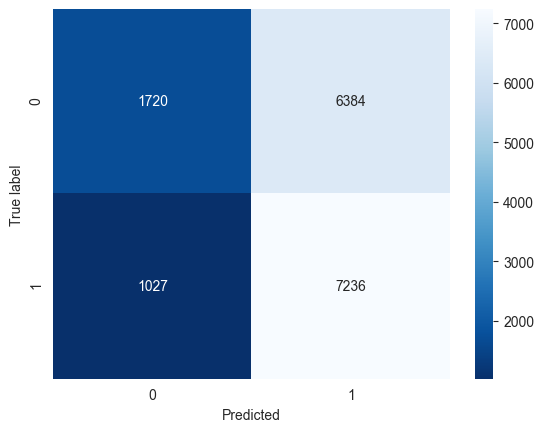

In [113]:
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

**Conclusion:**

- **True Negative (TN): 1933** – This represents the number of cases where the model correctly predicted that an accident would not happen, and indeed it did not occur.
- **True Positive (TP): 7074** – This represents the number of cases where the model correctly predicted that an accident would happen, and indeed it did.
- **False Negative (FN): 1189** – This represents the number of cases where the model predicted no accident would occur, but in reality, it did happen.
- **False Positive (FP): 6171** – This represents the number of cases where the model predicted an accident would happen, but in reality, it did not.

- **True Negative** and **True Positive** show the cases where the model made correct predictions.
- **False Negative** indicates cases where the model failed to recognize the potential for an accident, which can be dangerous as an accident occurred but was not predicted.
- **False Positive** indicates cases where the model predicted an accident, but none occurred. These errors are undesirable but less critical than false negatives because they result in a false alarm rather than missing an actual accident.

**Summary:**
- The model performs reasonably well in predicting accidents (7074 true positives), but it still makes a significant number of false alarms (6171 false positives).
- The false negatives (1189) are a crucial indicator, showing that the model failed to predict a number of accidents. This type of error could be critical, especially if it was possible to prevent those accidents.
- A high number of false positives could lead to excessive caution or unnecessary actions, but these errors are less harmful than false negatives since they lead to false alarms rather than missing real accidents.

# Analysis of the importance of accident factors

Plot a graph and examine how the features influence each prediction made by the model.

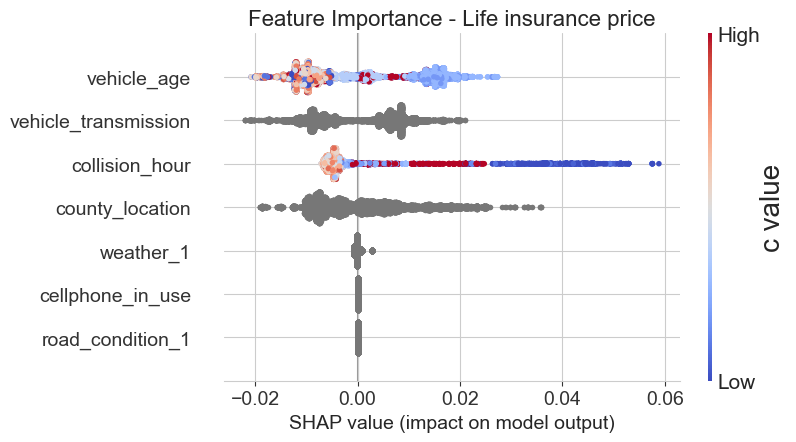

In [114]:
best_model_lgb = model_lgb.best_estimator_

explainer = shap.TreeExplainer(best_model_lgb)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Create a beeswarm plot for feature importance
shap.summary_plot(shap_values, X_test, cmap="coolwarm", show=False)

# Get the current figure and axes
fig, ax = plt.gcf(), plt.gca()

# Customize the main plot parameters
ax.tick_params(labelsize=14)
ax.set_xlabel("SHAP value (impact on model output)", fontsize=14)
ax.set_title('Feature Importance - Life insurance price', fontsize=16)

# Get the colorbar axis
cb_ax = fig.axes[1] 

# Customize the colorbar parameters
cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel("c value", fontsize=20)

plt.show()

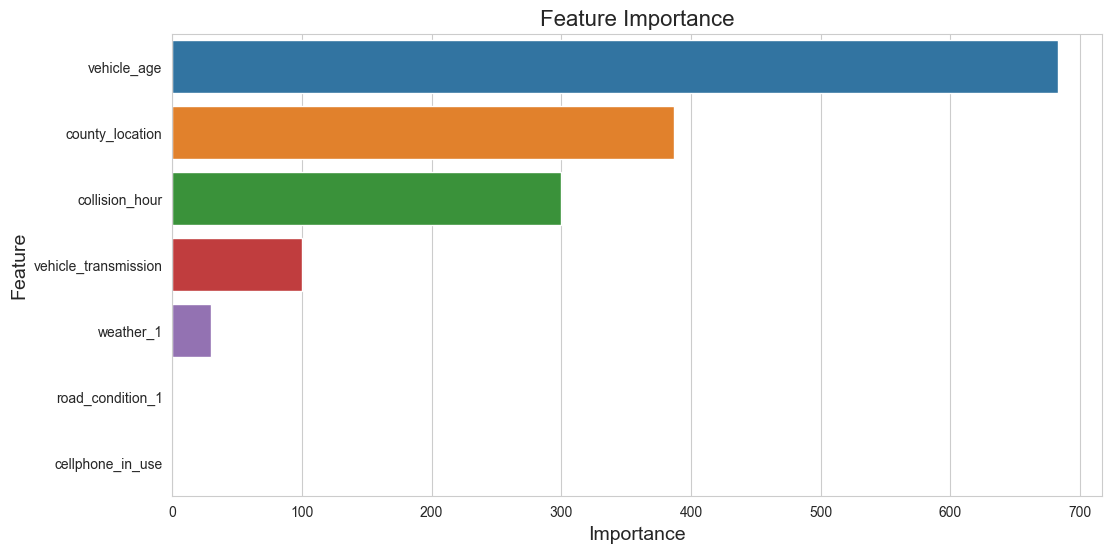

In [115]:
feature_importances = pd.DataFrame({'Feature': X_train.columns,
                                    'Importance': model_lgb.best_estimator_.feature_importances_})\
                      .sort_values('Importance', ascending=False)


plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Importance', y='Feature', data=feature_importances)
ax.set_title('Feature Importance', fontsize=16)
ax.set_xlabel('Importance', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
plt.show()

The main factors influencing the probability of an accident are:

- Vehicle age
- Vehicle usage area
- The hour at which the trip occurs.

### Analysis of the important factor – vehicle age.

In [116]:
data_1.loc[data_1['vehicle_age'] == 161, 'vehicle_age'] = 13

pivot_data = data_1.pivot_table(index='vehicle_age', 
                                columns='at_fault', 
                                aggfunc='size', 
                                fill_value=0)

# Renaming columns for clarity
pivot_data.columns = ['Not at fault', 'At fault']

# Resetting the index for easier display
pivot_data.reset_index(inplace=True)

pivot_data = pivot_data.reset_index()

print(pivot_data)

    index  vehicle_age  Not at fault  At fault
0       0          0.0          1729      1358
1       1          1.0          1472      1073
2       2          2.0          2635      3413
3       3          3.0          4205      6807
4       4          4.0          3402      3755
5       5          5.0          2984      2581
6       6          6.0          2192      1748
7       7          7.0          2095      1743
8       8          8.0          2047      1462
9       9          9.0          1582      1188
10     10         10.0          1115       827
11     11         11.0           733       647
12     12         12.0           436       443
13     13         13.0           253       300
14     14         14.0           120       162
15     15         15.0             8        29
16     16         16.0             4         2
17     17         17.0             1         2
18     18         19.0             0         1


<Figure size 1000x600 with 0 Axes>

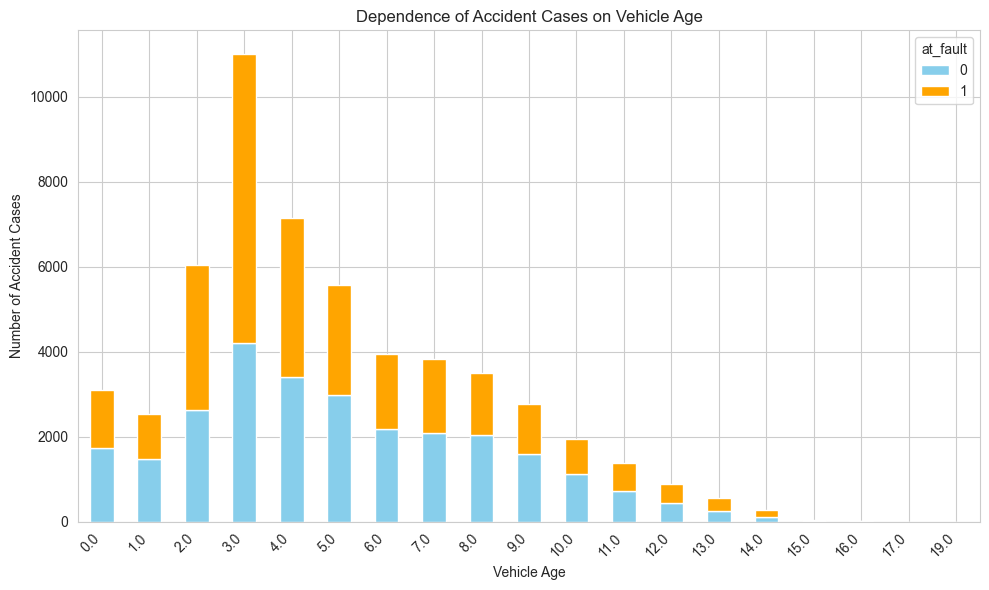

In [117]:
data_1.loc[data_1['vehicle_age'] == 161, 'vehicle_age'] = 13

sobriety_fault_counts = data_1.groupby(['vehicle_age', 'at_fault']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
sobriety_fault_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'orange'])

plt.xticks(rotation=45, ha='right')
plt.xlabel('Vehicle Age')
plt.ylabel('Number of Accident Cases')
plt.title('Dependence of Accident Cases on Vehicle Age')
plt.legend(title='at_fault', loc='upper right')
plt.tight_layout()
plt.show()

**Conclusion:**

- **New vehicles (0-2 years):**
For vehicles under 2 years old, the number of innocent drivers exceeds the number of at-fault drivers.

- **Vehicles 3-5 years old:**
In these age categories, there is an increase in the number of at-fault cases, especially for 3-year-old cars, where the number of at-fault drivers surpasses the number of innocent ones.

- **Vehicles 6-10 years old:**
From the age of 6, the number of at-fault cases gradually decreases, but it remains comparable to the number of innocent drivers. This may be related to vehicle wear and tear, but it could also indicate that drivers of older vehicles are more cautious.

- **Old vehicles (over 10 years old):**
For vehicles older than 10 years, there is a steady trend of decreasing both at-fault and innocent drivers. It is likely that older vehicles are used less frequently, leading to fewer accidents among them.

- **Very old vehicles (15+ years):**
In these categories, the number of accidents drops almost to zero. This could mean that such vehicles are rare on the roads or are used very minimally.

**Conclusions and Recommendations:**
- The decrease in accidents among new vehicles may indicate that newer vehicles are likely driven by more cautious drivers or are equipped with more modern safety systems.
- The peak in at-fault cases for vehicles aged 3-5 years may indicate the onset of vehicle wear and that these vehicles are in active use. It is recommended to focus on drivers of these categories for accident prevention.
- The decrease in accidents among older vehicles may be due to limited use or that they are driven by more cautious drivers. However, the condition of such vehicles needs to be monitored to reduce the risk of accidents due to technical reasons.

### Analysis of the important factor - country location

Let's conduct an additional analysis of the influence of the location on driver fault. Earlier, during the exploratory analysis, we looked at the top 15 most accident-prone cities in terms of driver fault. From this top list, we will select 3 cities where the number of at-fault drivers exceeds the number of innocent drivers, and we will also analyze the causes of accidents for the at-fault drivers.

In [118]:
graf_data = pd.DataFrame(graf_data)

cities = graf_data[graf_data['At fault'] > graf_data['Not at fault']]\
        .sort_values(by='At fault', ascending=False).head(3)
cities

,Not at fault,At fault
san diego,1679,1996
riverside,1598,1607
santa clara,872,907


In [119]:
# Filtering the rows by the required cities
cities_to_select = ['san diego', 'riverside', 'santa clara']
filtered_data = data_2[data_2['county_location'].isin(cities_to_select)]

# Keeping only the necessary columns
filtered_data = filtered_data[['at_fault', 'county_location', 'pcf_violation_category']]
# Keeping only rows where 'at_fault' is 1
filtered_data = filtered_data[filtered_data['at_fault'] == 1]

# Removing rows without an accident cause
filtered_data = filtered_data.dropna(subset=['pcf_violation_category'])
filtered_data = filtered_data.drop('at_fault', axis=1)
# Displaying information about the DataFrame
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4572 entries, 13 to 56239
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   county_location         4572 non-null   object
 1   pcf_violation_category  4572 non-null   object
dtypes: object(2)
memory usage: 107.2+ KB


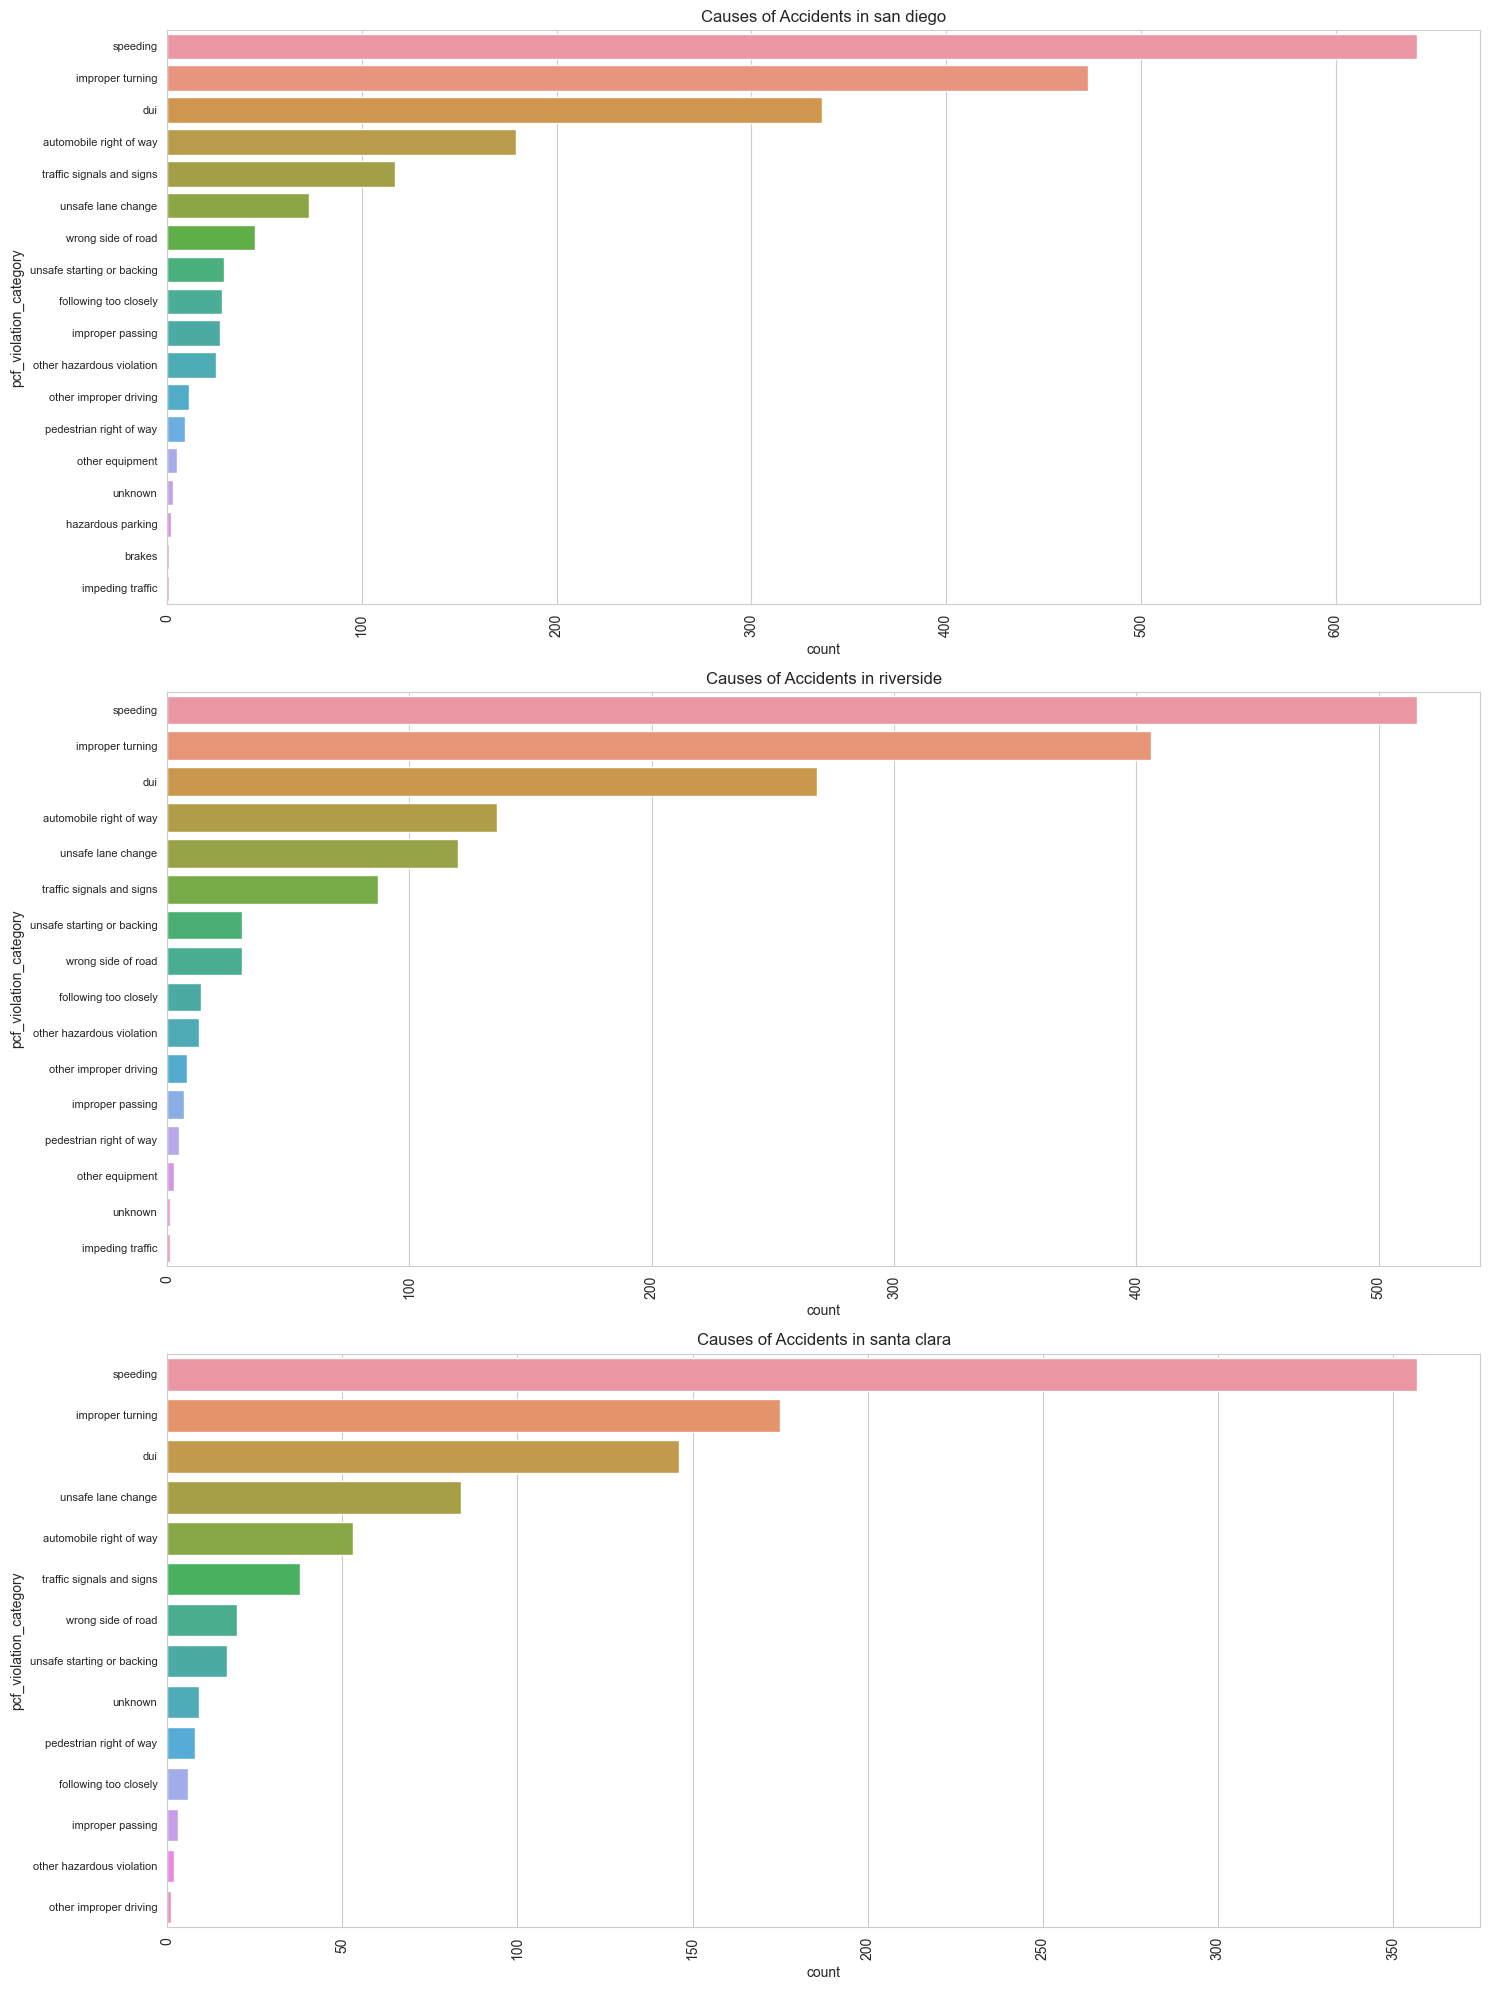

In [120]:
# Grouping data by 'county_location' and 'pcf_violation_category' and counting occurrences
grouped_data = filtered_data.groupby(['county_location', 'pcf_violation_category']).size().reset_index(name='count')

# Sorting the data by the count in descending order
grouped_data = grouped_data.sort_values(by='count', ascending=False)

# Creating plots for each city
unique_cities = grouped_data['county_location'].unique()

# Setting the size of the plots
plt.figure(figsize=(15, 20))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

# Creating the plots for each city
for i, city in enumerate(unique_cities):
    plt.subplot(len(unique_cities), 1, i+1)
    city_data = grouped_data[grouped_data['county_location'] == city]
    sns.barplot(y='pcf_violation_category', x='count', data=city_data)
    plt.title(f'Causes of Accidents in {city}')
    plt.xticks(rotation=90)
    plt.yticks(fontsize=8)

# Adjusting the layout of the plots
plt.tight_layout()
plt.show()

In the 3 cities with the highest number of accidents, the most common causes of accidents, which have the highest proportion of at-fault drivers, are the same. These are:

- Speeding violations.
- Violating turning rules.
- Driving under the influence of alcohol/drugs.

Therefore, to reduce the risk of accidents, I would suggest the following:

- Install speed limiters on vehicles, which will prevent speeding violations. The speed limit could be transmitted from the navigator.
- Equip vehicles with a user-friendly navigator that displays turn signs at upcoming intersections.
- Equip vehicles with an alcohol impairment analyzer. Measuring the driver’s condition upon entering the vehicle should be a mandatory condition for driving authorization.

# Conclusions

Our task was to develop a model for predicting the probability of a traffic accident.

The client had specific requirements for the algorithm:

- The type of at-fault party – only the car (car).
- Select cases where the accident resulted in any damage to the vehicle, except for the SCRATCH type.
- Limit the data to the year 2012.
- Consider the factor of vehicle age.
To solve the task, a database containing information about traffic accidents, participants, and their vehicles over several years was provided.


Factors influencing the number and fault in accidents

- The highest number of accidents occurs between January and May. This is likely related to challenging weather conditions, with roads covered in snow. In June, accidents sharply drop, and then gradually rise again toward the fall. Two peaks in incidents are observed in March and October, which are transitional months between the winter and summer seasons.

- Vehicles around 3 years old may face several issues such as reduced attention from owners, increased mileage, change of ownership, loss of factory settings, and wear of key components. These factors, combined with possible faults due to poor repairs, can negatively affect vehicle safety and increase the risk of accidents.

- Accidents are more frequent on dry roads, which suggests that driver safety is not solely dependent on road conditions. Wet and slippery roads, although less frequent, present increased dangers. Snowy and icy conditions cause fewer accidents, likely due to seasonal conditions and limited road usage.

- Clear and cloudy weather are associated with fewer fatalities and damages, while fog, rain, and wind increase the risk of serious accidents. Snow and fog raise the risks, especially for severe incidents.

- In the distribution of hours based on driver fault, there is a pattern where the number of at-fault drivers exceeds the number of innocent ones during nighttime and early morning hours. This may be due to driving under the influence of alcohol or fatigue.

- During the night, the likelihood of being at fault in an accident is higher than during the daytime. Around dawn and dusk, the number of at-fault and innocent drivers is about the same.

Additionally, after working with models, a strong non-linear relationship was found between the city of vehicle usage and driver fault. As a result, an analysis of the causes of driver fault in cities with the highest proportion of at-fault drivers was conducted. Three main causes of fault were identified:

- Speeding violations.
- Violating turning rules.
- Driving under the influence of alcohol/drugs (DUI).

**Recommendations for reducing the probability of accidents** 

Based on the analysis results, propose the following 3 recommendations aimed at reducing the likelihood of accidents:
- Install speed limiters on vehicles, which would prevent speeding. The speed limit could be transmitted from the vehicle's navigator.
- Equip vehicles with a user-friendly navigator that shows turn signs at upcoming intersections.
- Equip vehicles with an alcohol impairment analyzer. Measurement of the driver’s condition upon entering the vehicle should be a mandatory condition for allowing them to drive.

**Dataset used for model building**

The final dataset consisted of 7 input features:

- county_location – vehicle usage area.
- weather_1 – weather conditions.
- road_condition_1 – road surface condition.
- cellphone_in_use – use of a mobile phone.
- vehicle_transmission – type of transmission.
- vehicle_age – vehicle age.
- collision_hour – hour of the trip

All other features either had no impact on the target variable, duplicated selected features, or represented accident consequences.

**Model for predicting the target variable**

Several models were built to predict the driver’s fault in an accident. The quality of the models was evaluated using the F1 and recall metrics. Hyperparameter tuning was performed for each model. Additionally, a baseline solution was implemented using a DummyClassifier with settings where both target classes had an equal probability of being predicted. This led to random predictions. All models were compared with this baseline solution.

The best result was achieved using the LGBMClassifier with a learning rate of 0.001 and 50 trees. The advantage of this model is that it accurately identifies potential at-fault drivers, but the downside is that it incorrectly predicts fault for many innocent drivers. The results of all models are presented in the table below. 

**Conclusion:**

- The LightGBM model demonstrates good recall (83%), meaning it effectively identifies accident cases. However, its relatively low precision (53%) indicates that the model sometimes incorrectly predicts accidents when they don’t occur.
- An F1-Score of 66 indicates that the balance between precision and recall in the model is acceptable.
- 
This configuration of the LightGBM model demonstrated balanced precision and recall, suggesting satisfactory prediction quality.

In [121]:
table

,Model,Params,F1 Score,Recall Score
0,DummyClassifier,strategy=uniform,0.50,0.49
1,DecisionTreeClassifier,"{'models__min_samples_leaf': 6, 'models__max_f...",0.57,0.56
2,RandomForestClassifier,"{'classifier__n_estimators': 100, 'classifier_...",0.58,0.55
3,CatBoostClassifier,"{'n_estimators': 150, 'learning_rate': 0.1, 'd...",0.58,0.56
4,LGBMClassifier,"{'learning_rate': 0.001, 'n_estimators': 50}",0.66,0.86


**Recommendations:**

- **Driving Experience:** Consider the driver’s experience when analyzing accident rates and making decisions, as experience can directly affect the likelihood of accidents.

- **Sobriety Check:** Implement driver condition monitoring systems using sensors to require breathalyzer tests before each trip, ensuring the driver is not under the influence of alcohol.

- **Accident Database:** Establish a unified database linked to the driver’s license number to record all incidents. This will enable tracking of the driver’s history.

- **Alcohol Intoxication:** While alcohol is not the sole cause of accidents, crashes involving intoxicated drivers tend to be more severe. Therefore, special attention should be given to preventing drunk driving.

- **Vehicle Age:** Consider the age of the vehicle when assessing its technical condition. Regular maintenance and timely tire replacement based on seasonal requirements are also crucial safety factors.

- **Incomplete Data:** The current dataset mainly covers the period from January to May 2012, which may significantly distort the overall analysis. To achieve more accurate conclusions, it is necessary to collect and incorporate data from other months of the year.